#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [37]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 

from lifelines import CoxPHFitter

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [38]:
def cox_feature_select(data):    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()

    #computing max numer of samples 
    num_samples = data.shape[0]
    max_num_features = math.floor(num_samples/10)

    cph = CoxPHFitter()
    cph.fit(data, duration_col = time_column, event_col=event_column)  

    #getting coefficients
    hr = abs(cph.params_)

    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1,len(index_names)):
        col_names.append(index_names[x])

    col_names.append(time_column)
    col_names.append(event_column)

    filtered_data = data.filter(items=col_names, axis=1)
    print('Final dataset: \n', filtered_data)
    
    return filtered_data

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [40]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    if 'FFLP' in data.columns:
        data['time column']= data['FFLP_in_months']
        data['event column']= data['FFLP']
    elif 'AnyHepaticProgression' in data.columns:
        data['time column']= data['TimeToAnyHepaticProgression']
        data['event column']= data['AnyHepaticProgression']

    data1=data.drop(columns=['filename'])
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]


    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    #feature selecting by taking high odds variables from Cox regression if not enough samples
    
    data_temp = cox_feature_select(data2)
    data2 = data_temp
    
    # saving a copy to not repeat feature selection again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName)

    return data2

In [41]:
# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 12, 15, 20)
    max_depth=(1, 2, 3, 4, 5, 6, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    k_folds = 10
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [42]:
def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 4
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        
        c_index = concordance_index(xst, X_test, T_test, E_test)
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


# Scratchpad

In [12]:
results = []
data_name = 'clin_variables_all.csv'
processed_file_name = 'filtered_' + data_name 
if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
else:
    filtered_data = pd.read_csv(processed_file_name)
    print('Loading existing selected features...\n')
    
print('\n \n')


print('Running gridsearch on: ' + data_name + '\n')

gridsearch_file_name = 'gridsearch_' + data_name 
    
if(not(os.path.exists(gridsearch_file_name))):
    print('Computing gridsearch...\n')
    (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
    print((c_index_best, num_tree_best,max_depth_best, min_node_best))
else:
    gridsearch_df = pd.read_csv(gridsearch_file_name)

    c_index_best = gridsearch_df['Values'][0]
    num_tree_best = gridsearch_df['Values'][1]
    max_depth_best = gridsearch_df['Values'][2]
    min_node_best = gridsearch_df['Values'][3]

    #print(c_index_best)
    print('Loading existing gridsearch hyperparameters...\n')

# generating model form best gridsearch combination

print('Evaluating K-folds with best hyperparameter combination...\n')
(CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)

results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
print('\n \n')
results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

Computing feature selection...

dropping 'FFLP' at index: 41
dropping 'FFLP_in_months' at index: 41
dropping 'Histology' at index: 1
dropping 'RTPlanDose' at index: 8
dropping 'Intended Rx dose' at index: 10
dropping 'D95 (dose in cGy)' at index: 15
dropping 'Dmax (cGy)' at index: 14
dropping 'D95 (% of intended Rx dose)' at index: 14
dropping 'NumLiverLesionsAtRT.1' at index: 31
dropping 'BED (in Gy)' at index: 11
dropping 'RTnumFx' at index: 6
dropping 'SystemicBeforeRT' at index: 15
dropping 'RTDoseDeliv' at index: 7
dropping 'Lesion1Dim1' at index: 28
dropping 'MinDosePTV (cGy)' at index: 10
dropping 'AnyHepaticProgression' at index: 28
dropping 'Gender' at index: 0
Remaining variables:
Index(['HistologyGranular', 'cM at diagnosis', 'NumLiverLesionsAtDx',
       'OtherSitesAtDx', 'RTtoOtherSites', 'RTFxDeliv', 'DosePainting',
       'Dose per fx', 'PTVvolume (cm^3)', 'LiverLocation2Tx', 'ReTx',
       'SurgeryBeforeRT', 'Lines of chemo', 'PumpBeforeRT', 'RFAbeforeRT',
       'RFAto

KeyboardInterrupt: 

### Main script starts here

In [55]:
#creating subsets of clinical variables
clin_variables_name = 'clin_variables_all.csv'
clin_variables_all = pd.read_csv(clin_variables_name) 
cols_irrelevant = ['P53', 'BRAF', 'MSS/MSI']
cols_imaging = ['filename', 'NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2',
                'PTVvolume (cm^3)']
cols_dosimetric = ['filename', 'BED (in Gy)','MinDosePTV (cGy)','Dmax (cGy)', 'D95 (% of intended Rx dose)',
                  'SystemicBeforeRT', 'Lines of chemo','PumpBeforeRT', 'CEAatRT', 'KRASmutation']
cols_imaging_no_file_name = ['NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2',
                'PTVvolume (cm^3)']
cols_hp = ['AnyHepaticProgression', 'TimeToAnyHepaticProgression']
cols_fflp = ['FFLP_in_months', 'FFLP']


clin_variables_no_mut = clin_variables_all.drop(columns = cols_irrelevant)

clin_variables_non_imaging = clin_variables_no_mut.drop(columns = cols_imaging_no_file_name)
clin_variables_non_imaging_fflp = clin_variables_non_imaging.drop(columns = cols_hp)
clin_variables_non_imaging_hp = clin_variables_non_imaging.drop(columns = cols_fflp)
clin_variables_non_imaging_fflp.to_csv('clin_variables_non_imaging_fflp.csv', index=False)
clin_variables_non_imaging_hp.to_csv('clin_variables_non_imaging_hp.csv', index=False)

clin_variables_imaging_fflp = clin_variables_no_mut[cols_imaging + cols_fflp]
clin_variables_imaging_hp = clin_variables_no_mut[cols_imaging + cols_hp]
clin_variables_imaging_fflp.to_csv('clin_variables_imaging_fflp.csv', index=False)
clin_variables_imaging_hp.to_csv('clin_variables_imaging_hp.csv', index=False)

clin_variables_dosimetric_fflp = clin_variables_no_mut[cols_dosimetric + cols_fflp ]
clin_variables_dosimetric_hp = clin_variables_no_mut[cols_dosimetric + cols_hp ]
clin_variables_dosimetric_fflp.to_csv('clin_variables_dosimetric_fflp.csv', index=False)
clin_variables_dosimetric_hp.to_csv('clin_variables_dosimetric_hp.csv', index=False)


In [56]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

#outcome as local progression
gtv_fflp = 'gtv.csv'
liver_sub_gtv_fflp = 'liver_sub_gtv.csv'
liver_plus_gtv_fflp = 'liver_plus_gtv.csv'


#gtv_clin_variables = 'gtv_clin_variables.csv'
#liver_sub_gtv_clin_variables = 'liver_sub_gtv_clin_variables.csv'
#liver_plus_gtv_clin_variables = 'liver_plus_gtv_clin_variables.csv'
#gtv0_clin_variables = 'gtv_0_clin_variables.csv'

#outcome defined as any hepatic progression
gtv_hp = 'gtv_hp.csv'
liver_sub_gtv_hp = 'liver_sub_gtv_hp.csv'
liver_plus_gtv_hp = 'liver_plus_gtv_hp.csv'


#clinical vairables
clin_variables_imaging_fflp = 'clin_variables_imaging_fflp.csv'
clin_variables_non_imaging_fflp = 'clin_variables_non_imaging_fflp.csv'
clin_variables_dosimetric_fflp = 'clin_variables_dosimetric_fflp.csv'

#any hepatic progression
clin_variables_imaging_hp = 'clin_variables_imaging_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'
clin_variables_dosimetric_hp = 'clin_variables_dosimetric_hp.csv'


clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'

data_list = list()
data_list.extend((gtv_fflp, liver_sub_gtv_fflp, liver_plus_gtv_fflp, gtv_hp, liver_sub_gtv_hp, liver_plus_gtv_hp,
                 clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, clin_variables_dosimetric_fflp,
                 clin_variables_imaging_hp, clin_variables_non_imaging_hp, clin_variables_dosimetric_hp))

In [34]:
# file integrity test
for data_name in data_list:
    test  = pd.read_csv(data_name)

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


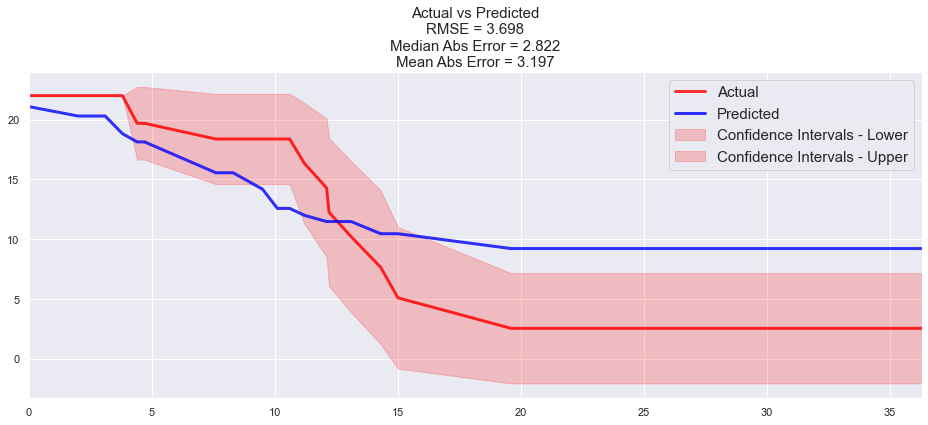

C-index: 0.53
IBS: 0.17

 2 of kfold 4


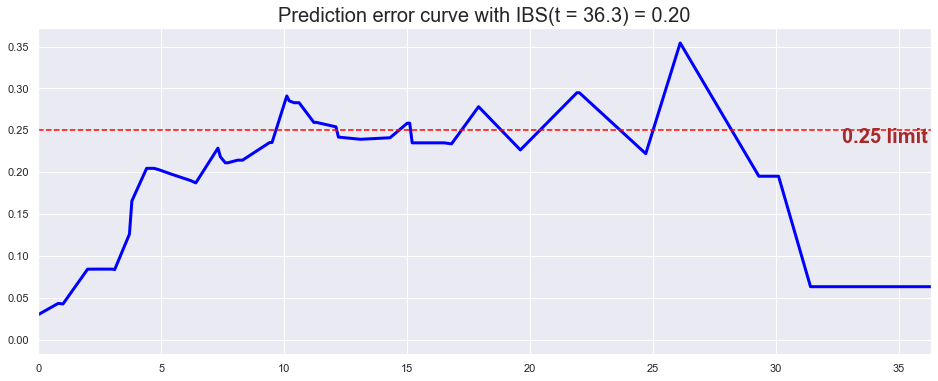

C-index: 0.62
IBS: 0.20

 3 of kfold 4


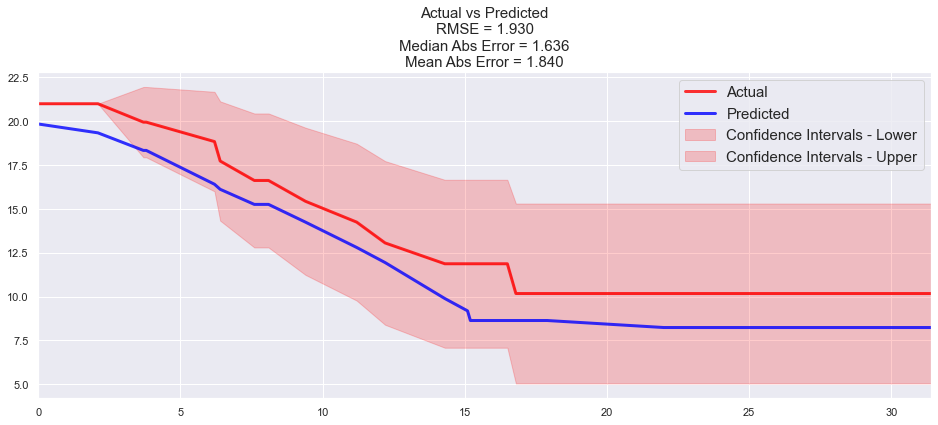

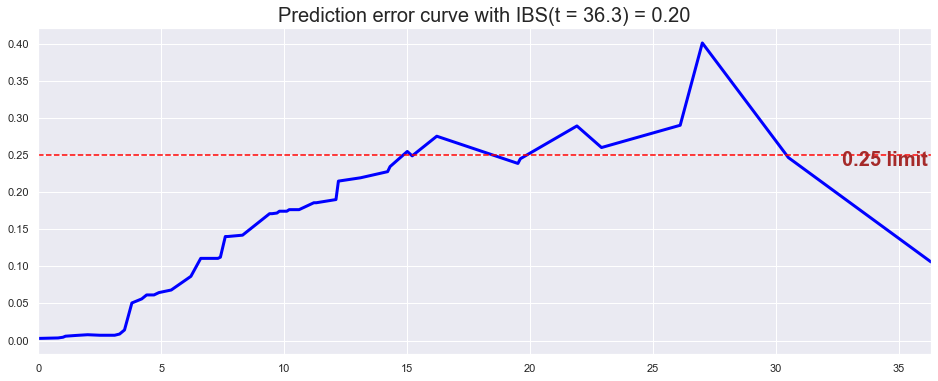

C-index: 0.73
IBS: 0.20

 4 of kfold 4


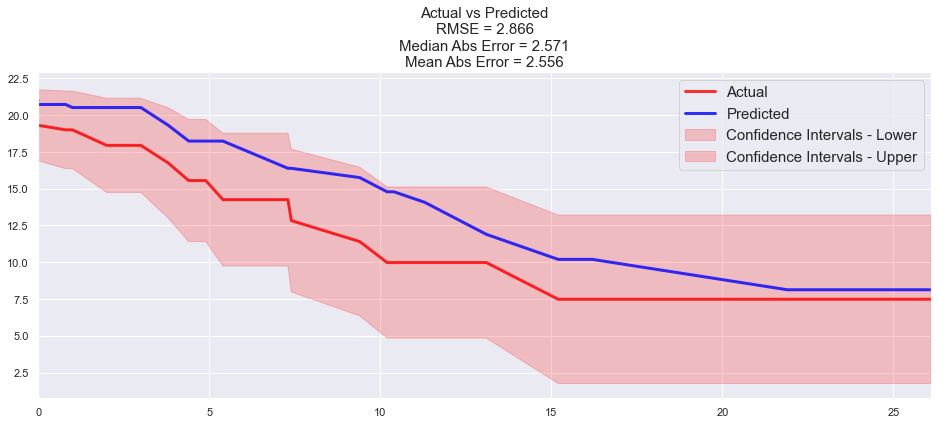

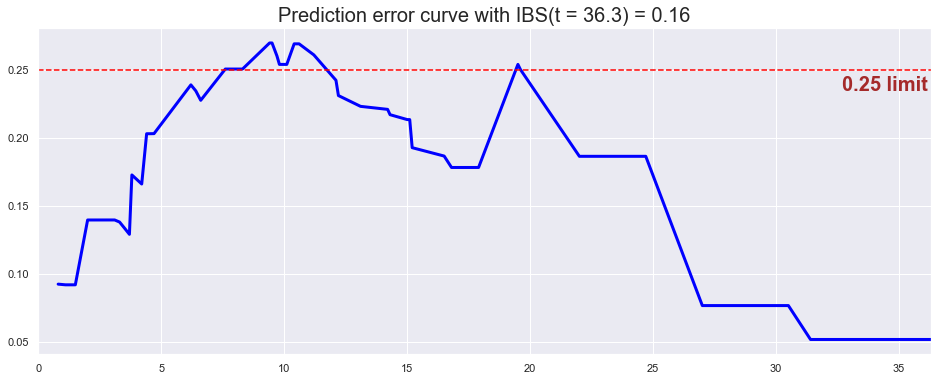

C-index: 0.74
IBS: 0.16

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


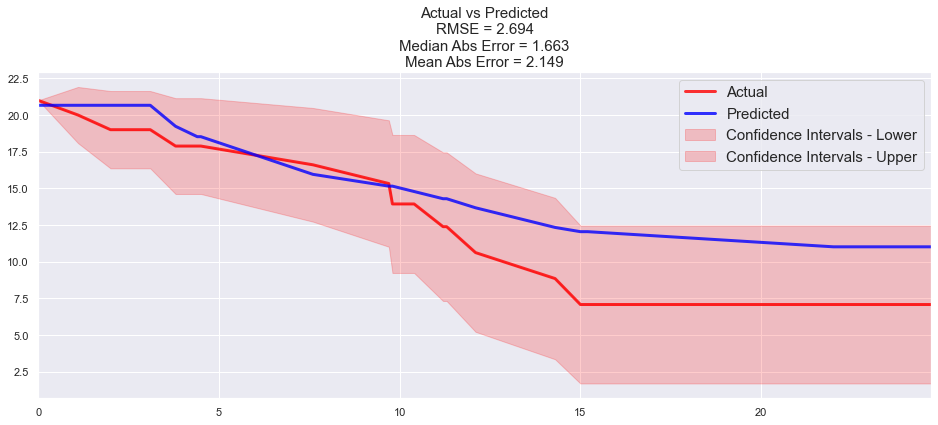

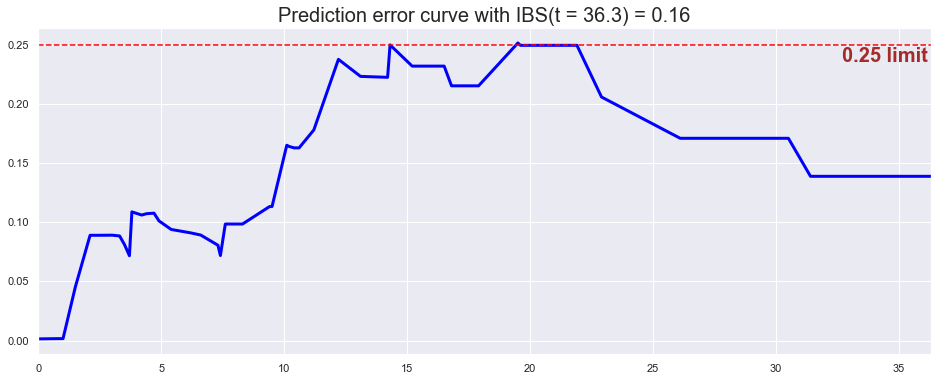

C-index: 0.77
IBS: 0.16

 2 of kfold 4


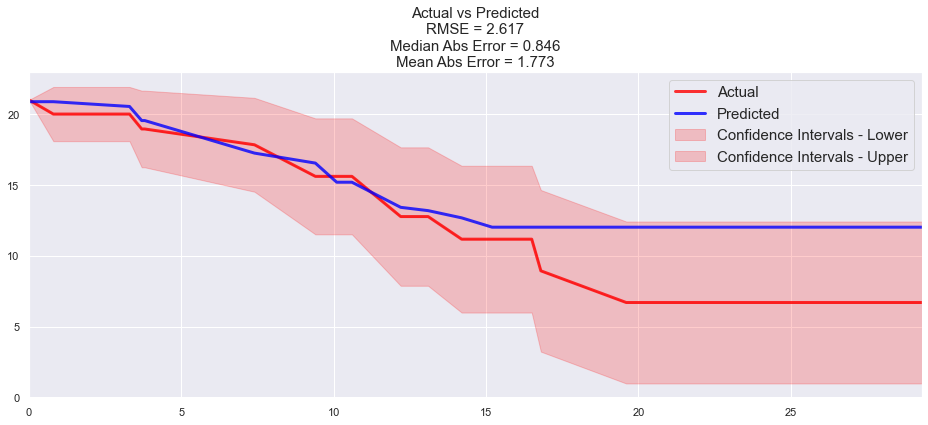

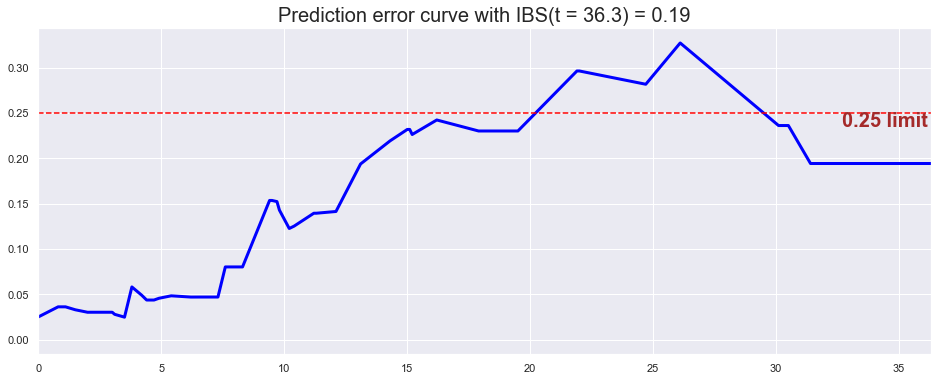

C-index: 0.75
IBS: 0.19

 3 of kfold 4


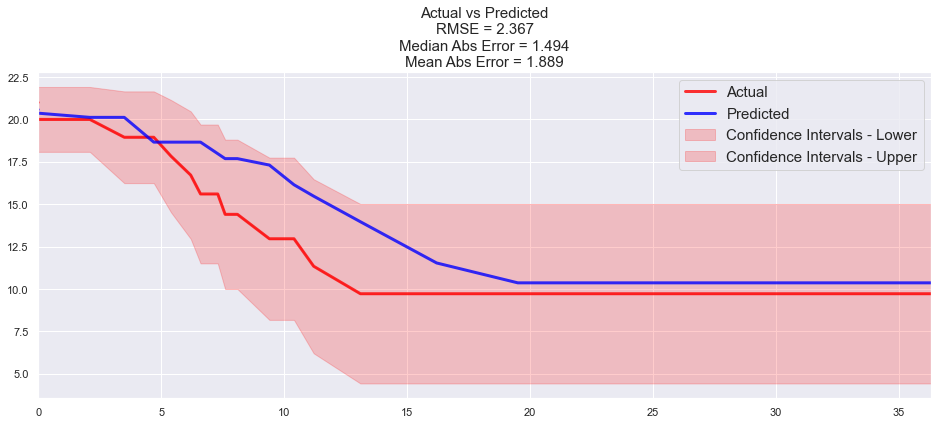

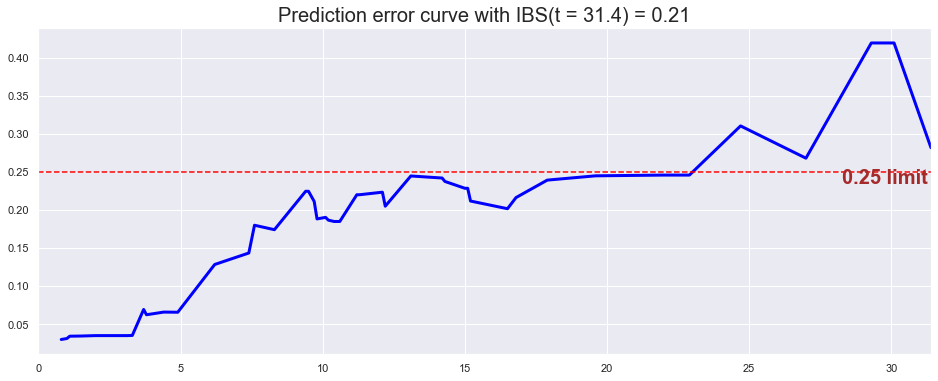

C-index: 0.83
IBS: 0.21

 4 of kfold 4


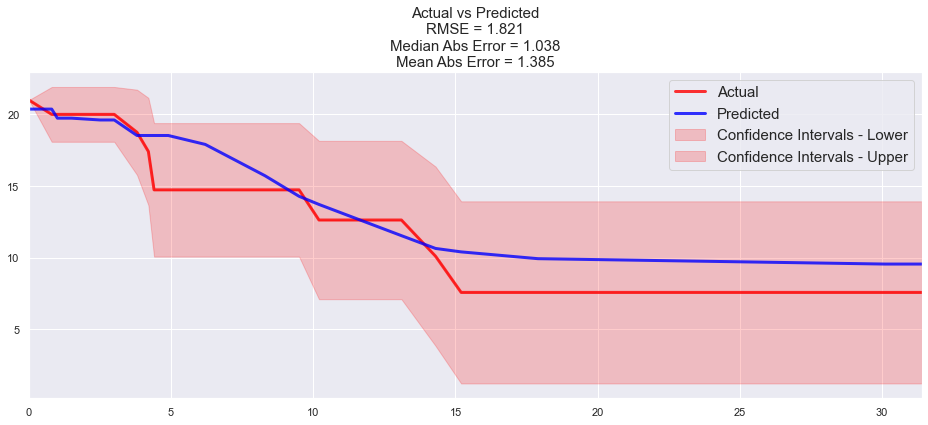

C-index: 0.68
IBS: 0.22

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


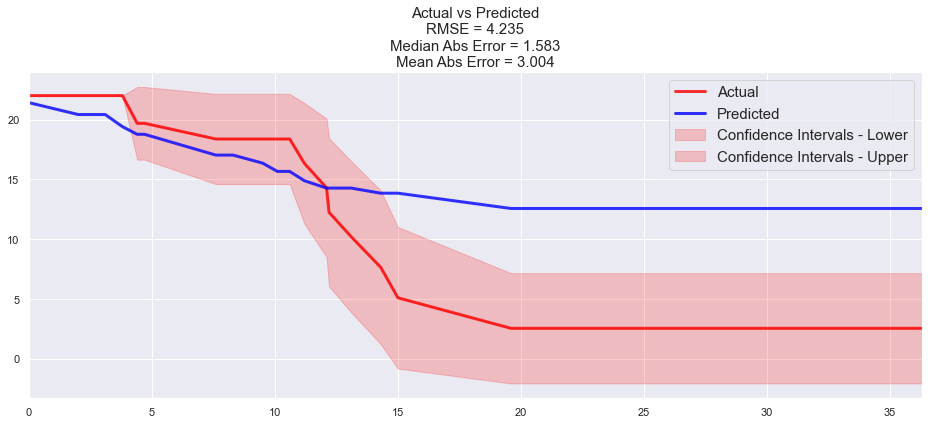

C-index: 0.54
IBS: 0.23

 2 of kfold 4


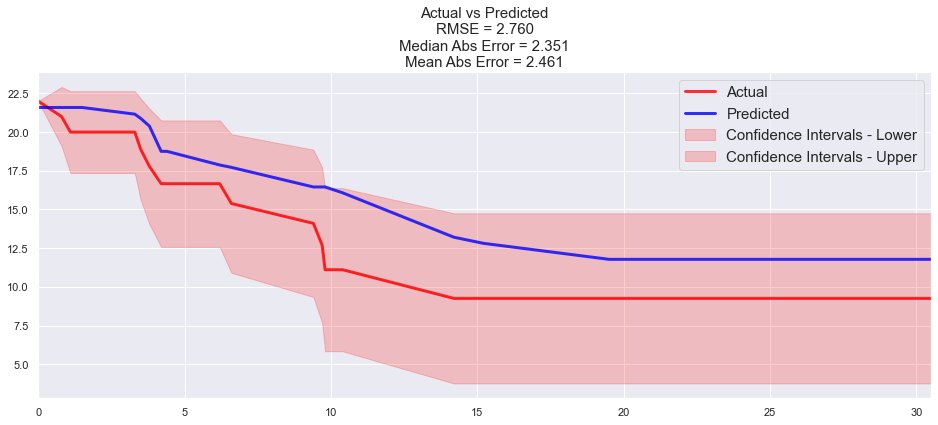

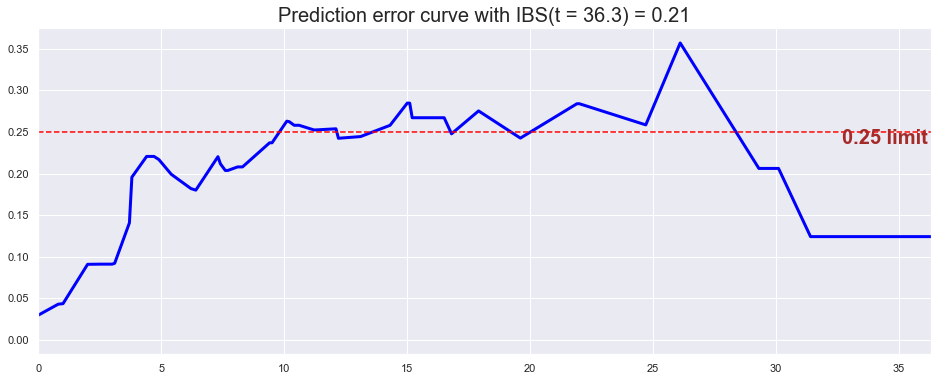

C-index: 0.63
IBS: 0.21

 3 of kfold 4


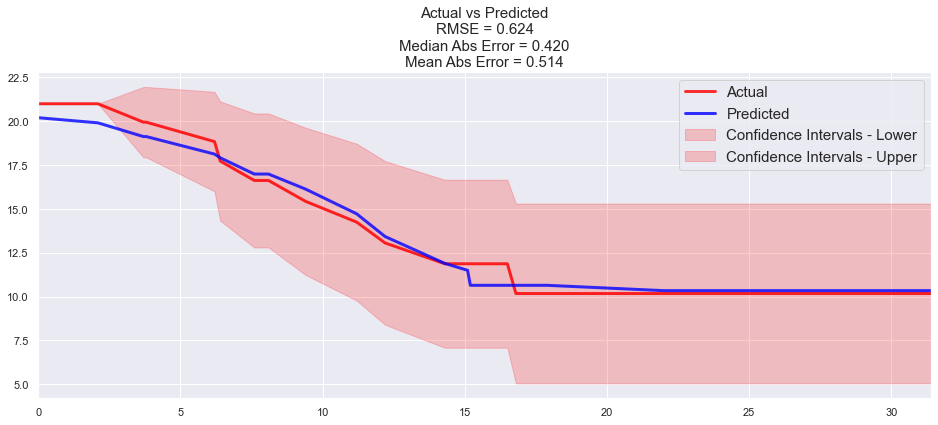

C-index: 0.71
IBS: 0.21

 4 of kfold 4


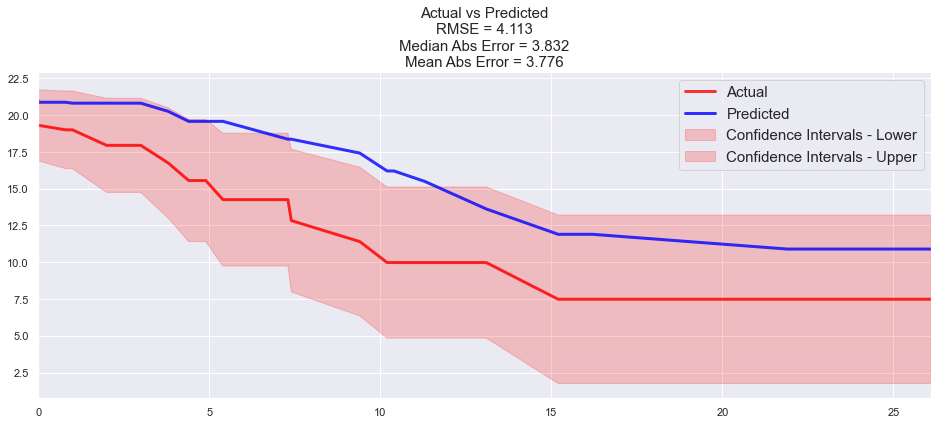

C-index: 0.66
IBS: 0.22

 

Processing: gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


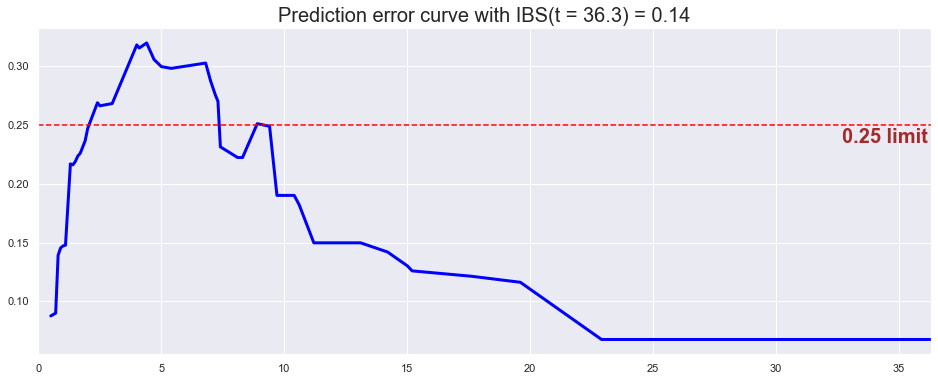

C-index: 0.68
IBS: 0.14

 2 of kfold 4


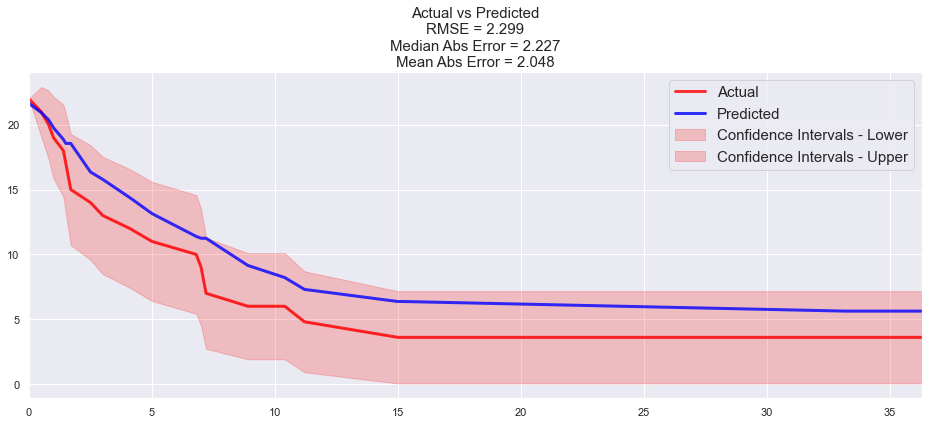

C-index: 0.56
IBS: 0.20

 3 of kfold 4


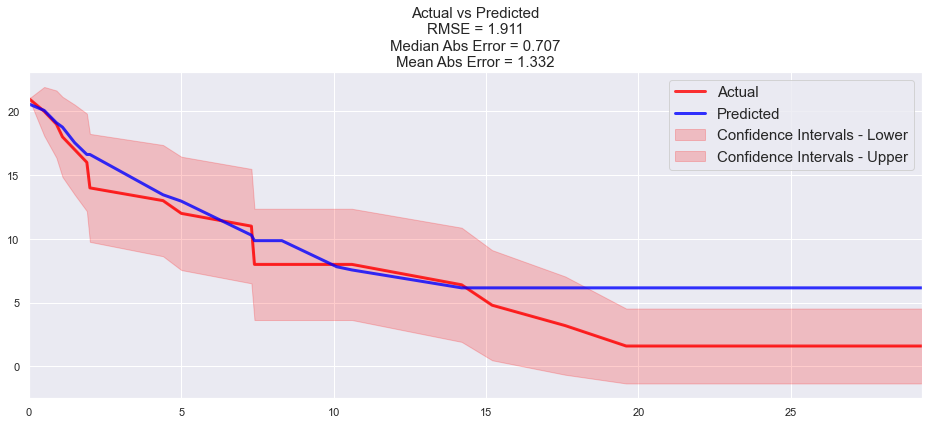

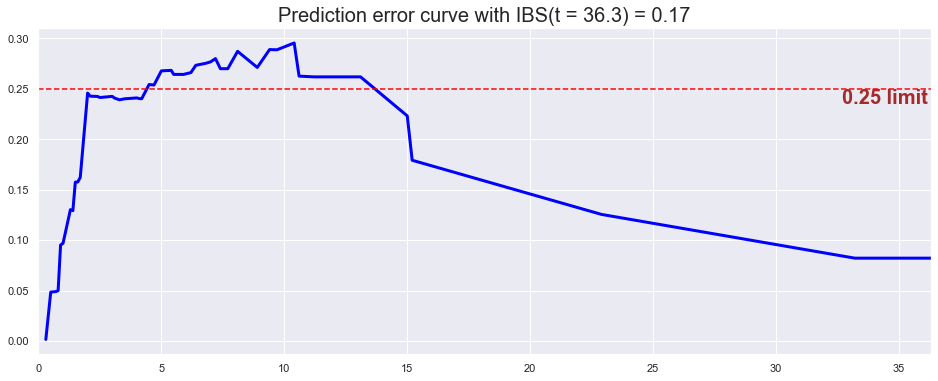

C-index: 0.65
IBS: 0.17

 4 of kfold 4


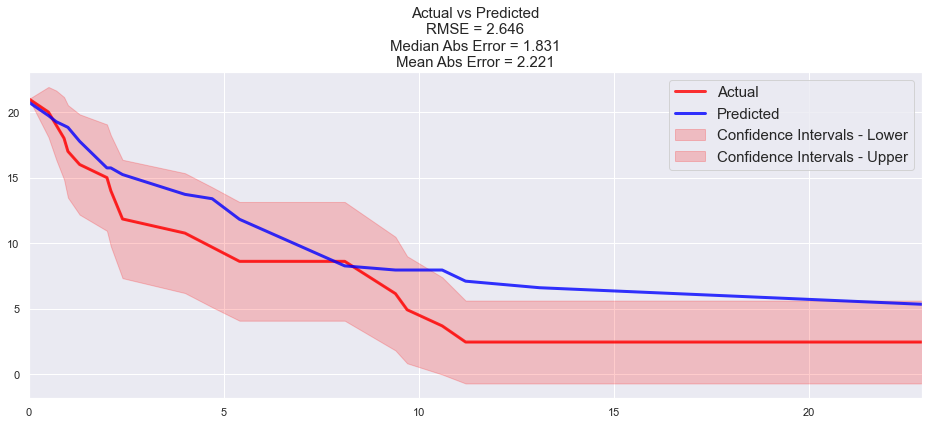

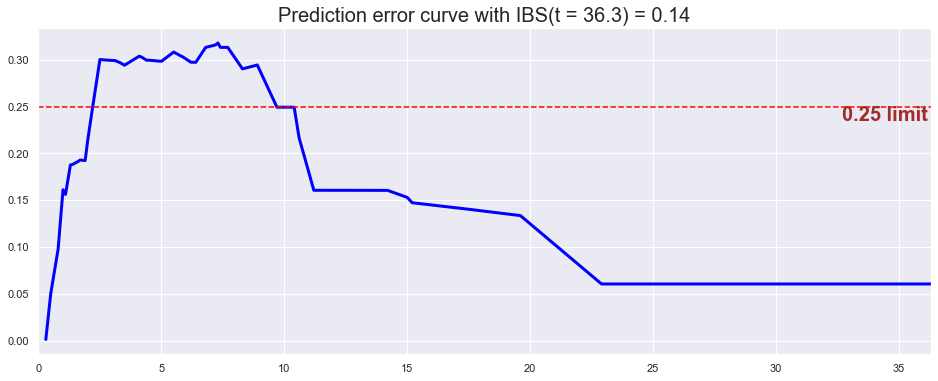

C-index: 0.56
IBS: 0.14

 

Processing: liver_sub_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


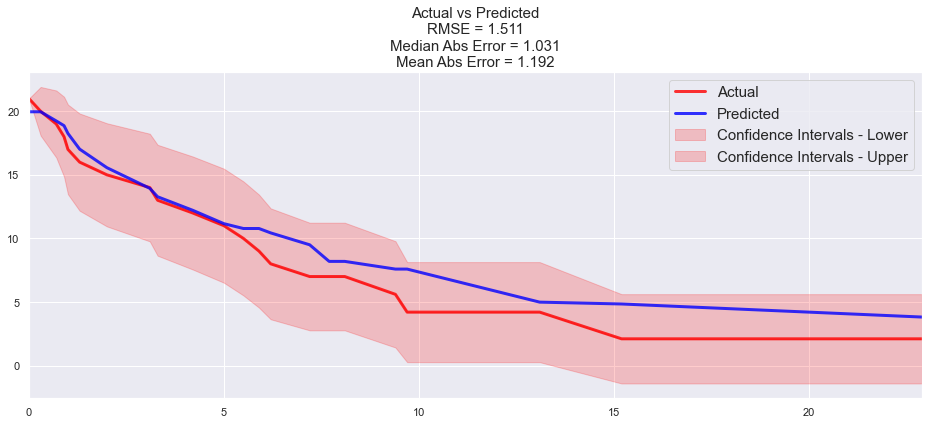

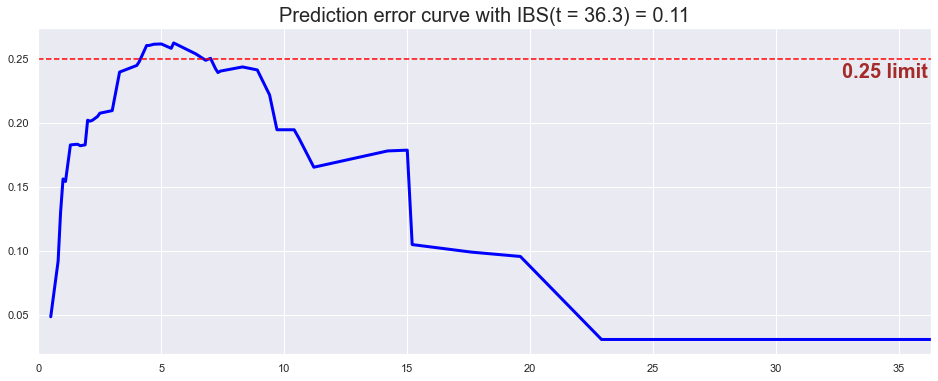

C-index: 0.50
IBS: 0.11

 2 of kfold 4


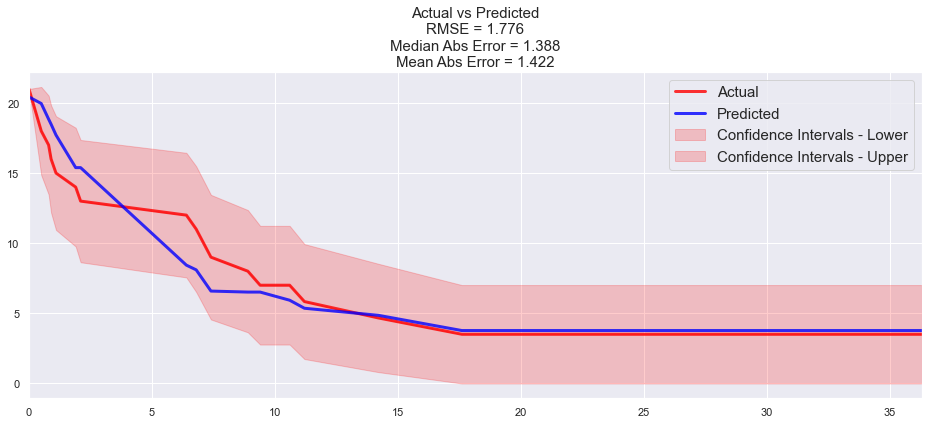

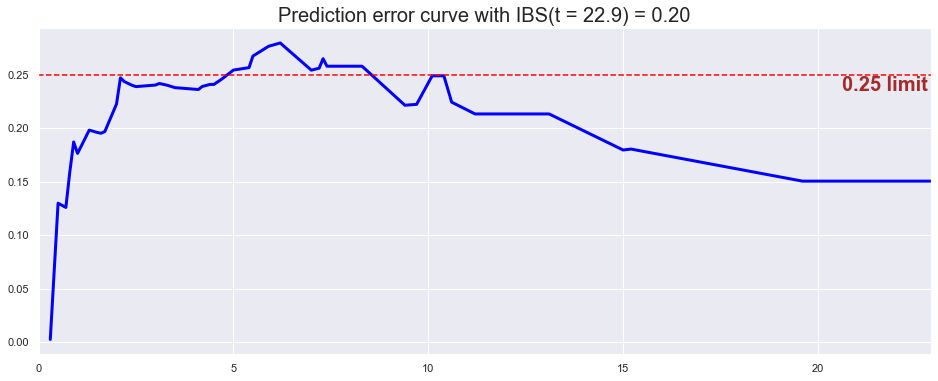

C-index: 0.52
IBS: 0.20

 3 of kfold 4


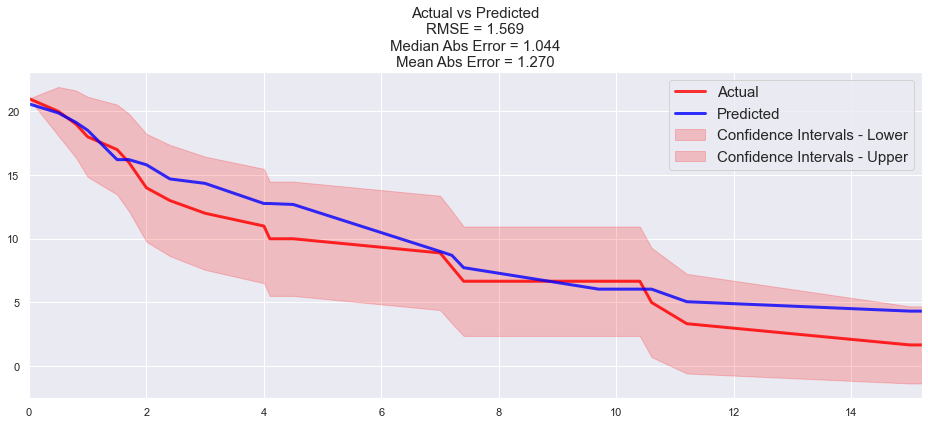

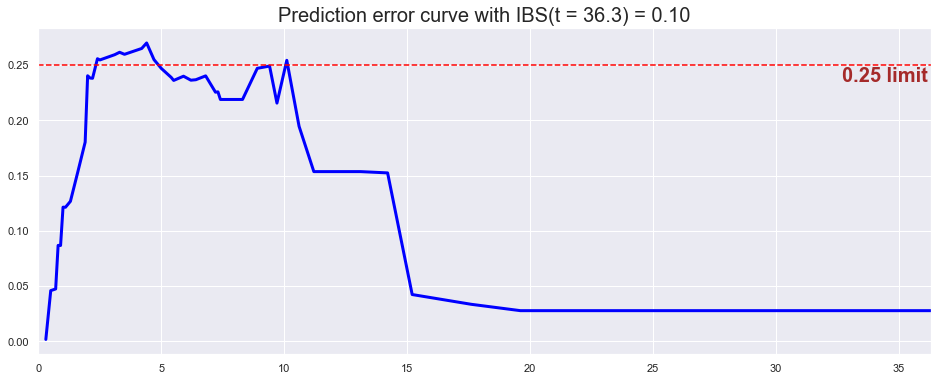

C-index: 0.53
IBS: 0.10

 4 of kfold 4


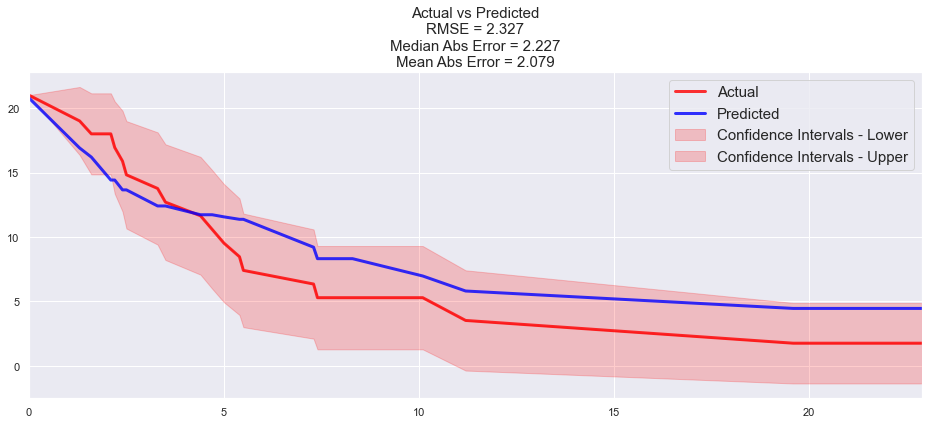

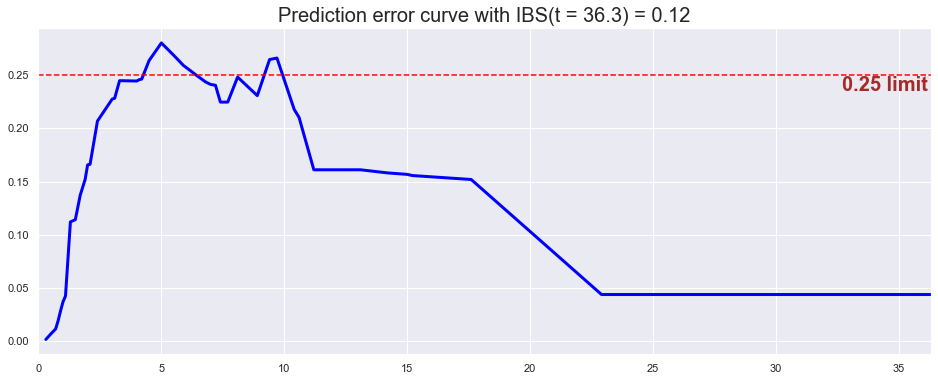

C-index: 0.52
IBS: 0.12

 

Processing: liver_plus_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


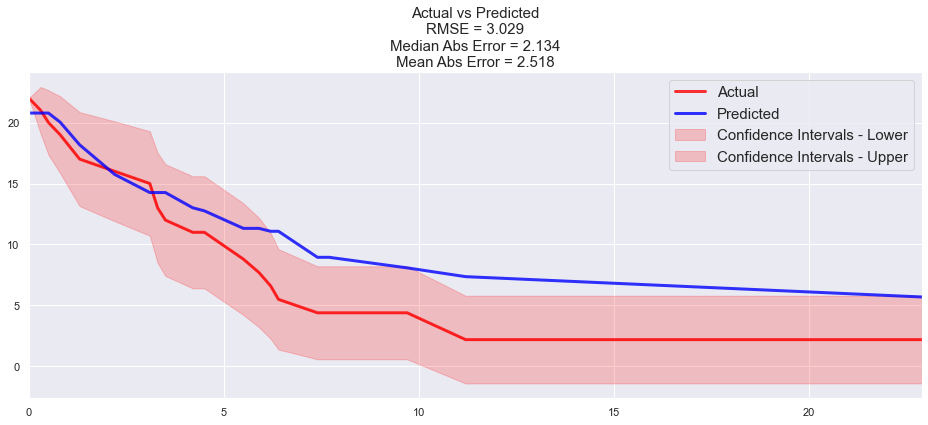

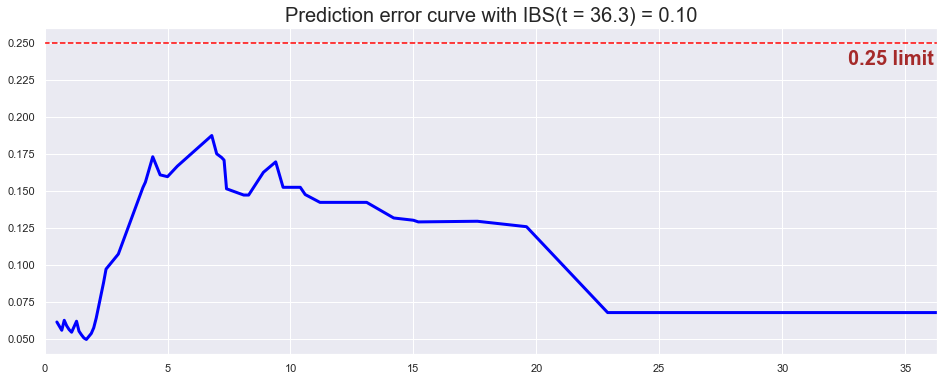

C-index: 0.81
IBS: 0.10

 2 of kfold 4


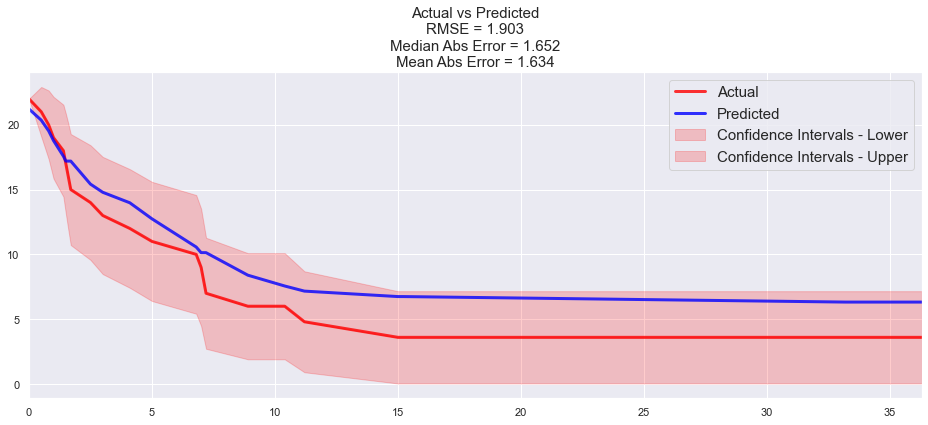

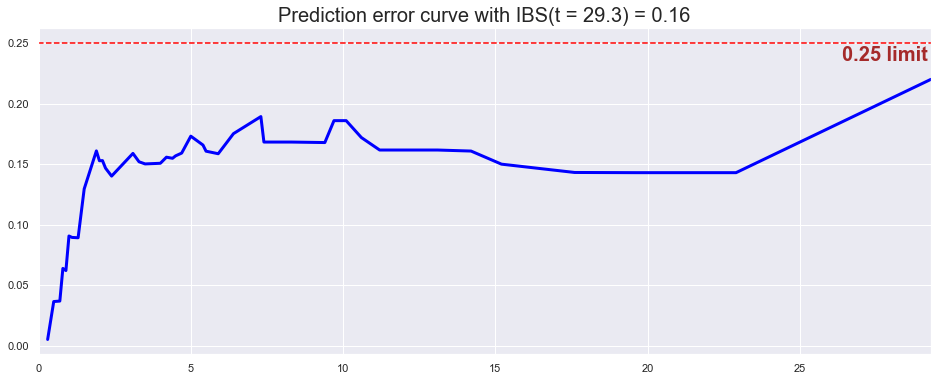

C-index: 0.77
IBS: 0.16

 3 of kfold 4


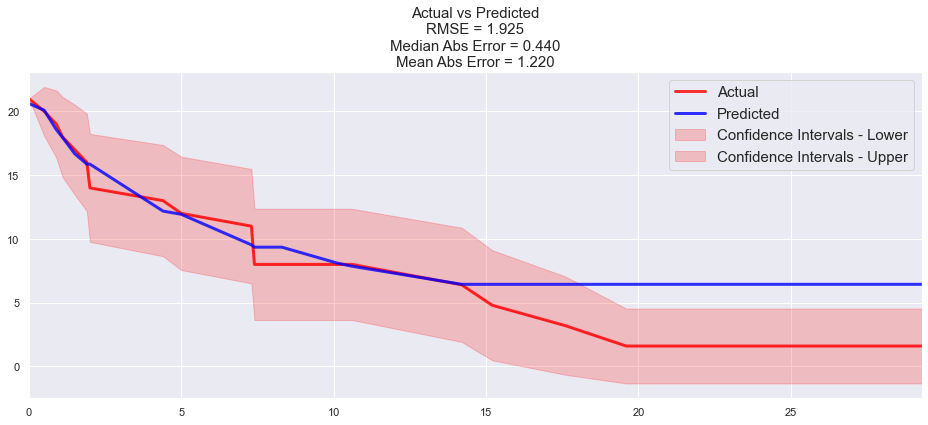

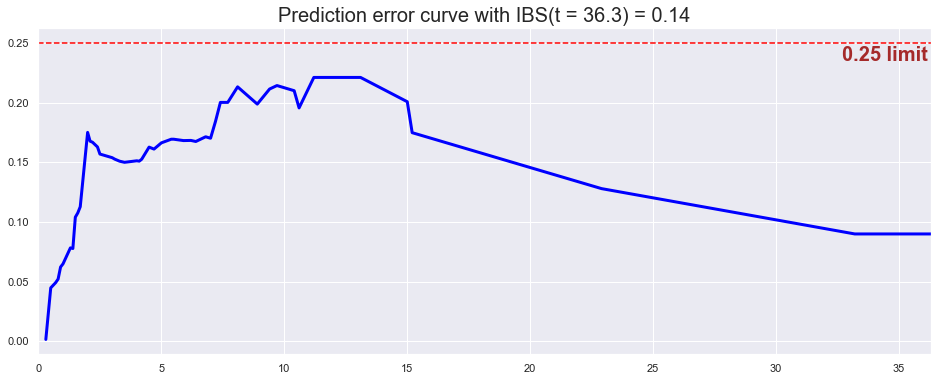

C-index: 0.79
IBS: 0.14

 4 of kfold 4


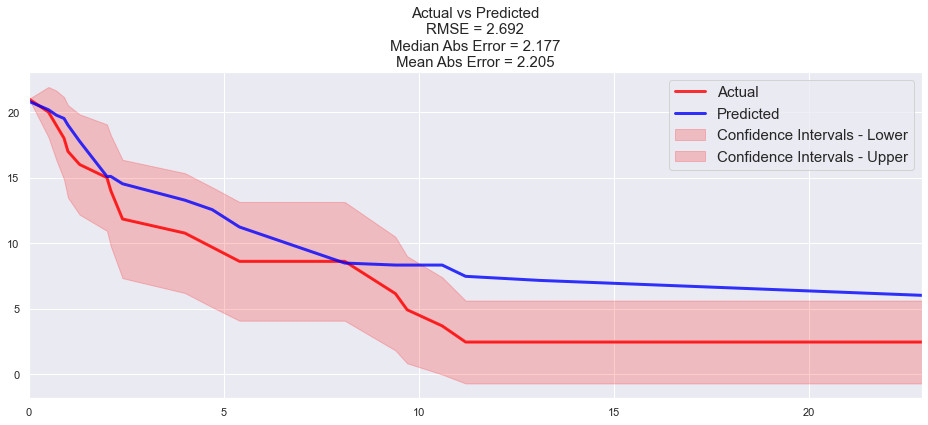

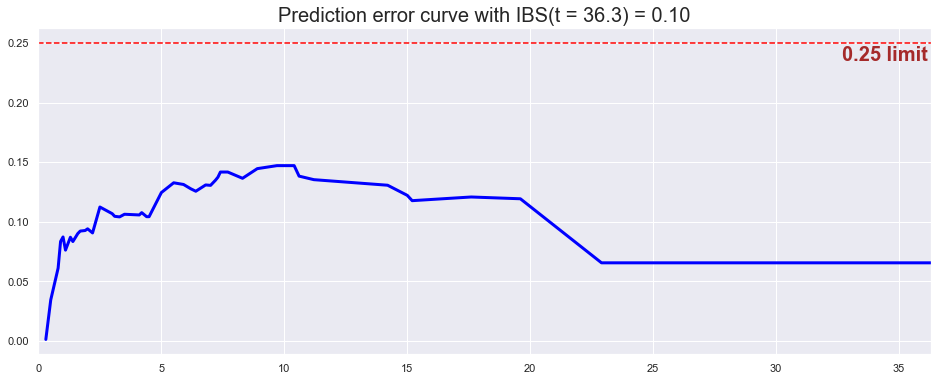

C-index: 0.89
IBS: 0.10

 

Processing: clin_variables_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 4


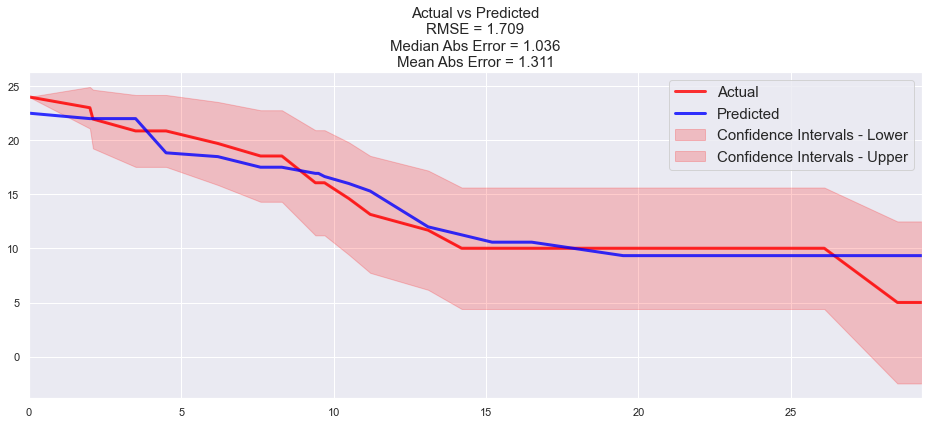

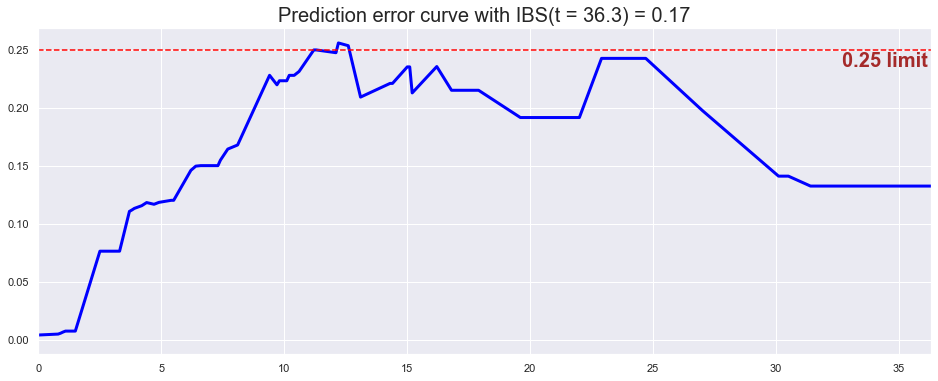

C-index: 0.55
IBS: 0.17

 2 of kfold 4


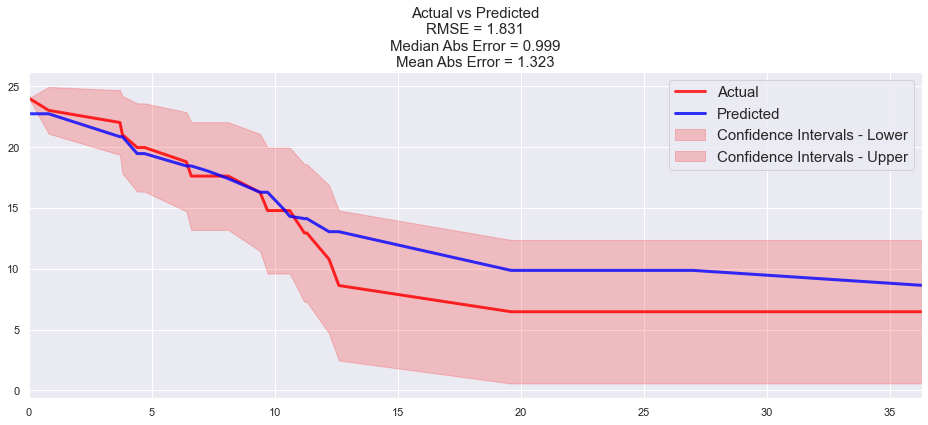

C-index: 0.65
IBS: 0.19

 3 of kfold 4


C-index: 0.70
IBS: 0.20

 4 of kfold 4


C-index: 0.56
IBS: 0.19

 

Processing: clin_variables_non_imaging_fflp.csv

Feature Selecting... 

Computing feature selection...

dropping 'FFLP' at index: 33
dropping 'FFLP_in_months' at index: 33
dropping 'Histology' at index: 1
dropping 'RTPlanDose' at index: 8
dropping 'D95 (dose in cGy)' at index: 15
dropping 'Intended Rx dose' at index: 10
dropping 'Dmax (cGy)' at index: 13
dropping 'D95 (% of intended Rx dose)' at index: 13
dropping 'BED (in Gy)' at index: 11
dropping 'RTFxDeliv' at index: 7
dropping 'SystemicBeforeRT' at index: 14
dropping 'MinDosePTV (cGy)' at index: 10
dropping 'RTDoseDeliv' at index: 7
Remaining variables:
Index(['Gender', 'HistologyGranular', 'cM at diagnosis', 'NumLiverLesionsAtDx',
       'OtherSitesAtDx', 'RTtoOtherSites', 'RTnumFx', 'DosePainting',
       'Dose per fx', 'LiverLocation2Tx', 'ReTx', 'SurgeryBeforeRT',
       'Lines of chemo', 'PumpBeforeRT', 'RFAbeforeRT', 'RFAtoRTlesions',
       'Y90BeforeRT', 'EmbolizationBeforeRT', 'CEAatDx', 'CEAat

15 4 2 0.6506931958476163
15 4 3 0.6296474761795459
15 4 4 0.679831047250137
15 4 5 0.6148164996259217
15 4 10 0.5926613168149948
15 4 12 0.6071369885762634
15 4 15 0.6722326518930299
15 4 20 0.6278334739490807
15 5 1 0.6263360191530059
15 5 2 0.6723901102332465
15 5 3 0.6417810998946029
15 5 4 0.6273005495956028
15 5 5 0.6360303994131488
15 5 10 0.6679360354693972
15 5 12 0.6323960038089035
15 5 15 0.6186364345124492
15 5 20 0.6008611031672785
15 6 1 0.6777255650449026
15 6 2 0.629854484694331
15 6 3 0.6146159465227818
15 6 4 0.5897789537728533
15 6 5 0.6289565631089027
15 6 10 0.6330544858283657
15 6 12 0.6373509451077325
15 6 15 0.6329890445573585
15 6 20 0.6150469506601279
15 10 1 0.6395088731948254
15 10 2 0.6246691717690107
15 10 3 0.5975113930748243
15 10 4 0.6268514843965493
15 10 5 0.6625790267483372
15 10 10 0.5971867547162263
15 10 12 0.6153145768440705
15 10 15 0.5929256620227455
15 10 20 0.5892684583401679
15 12 1 0.6722621128005479
15 12 2 0.6518180314827924
15 12 3 0.629

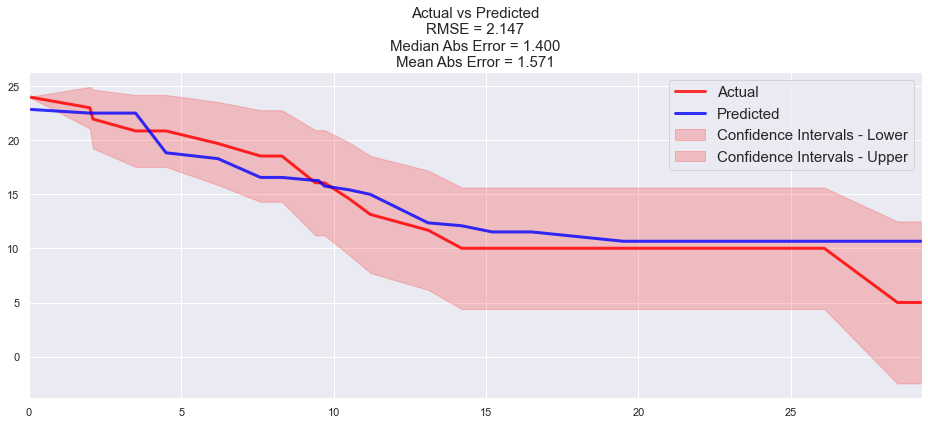

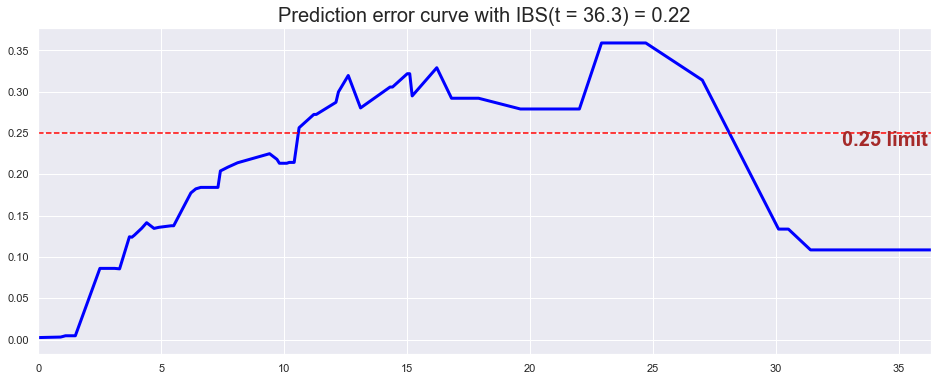

C-index: 0.52
IBS: 0.22

 2 of kfold 4


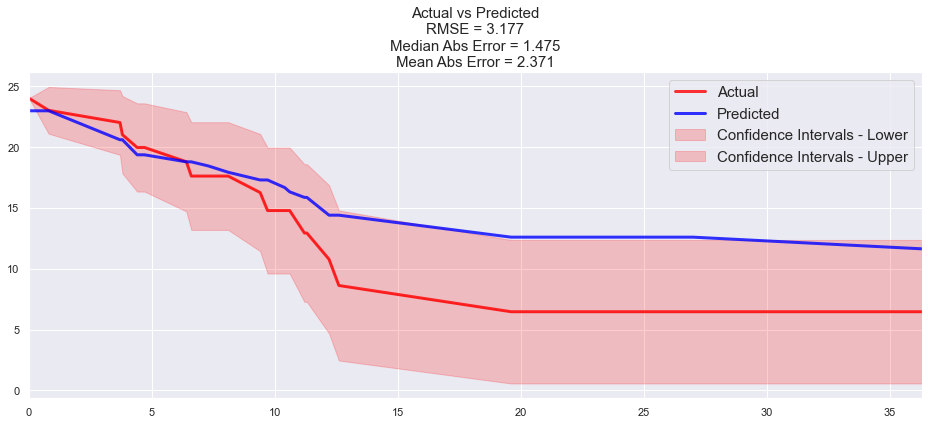

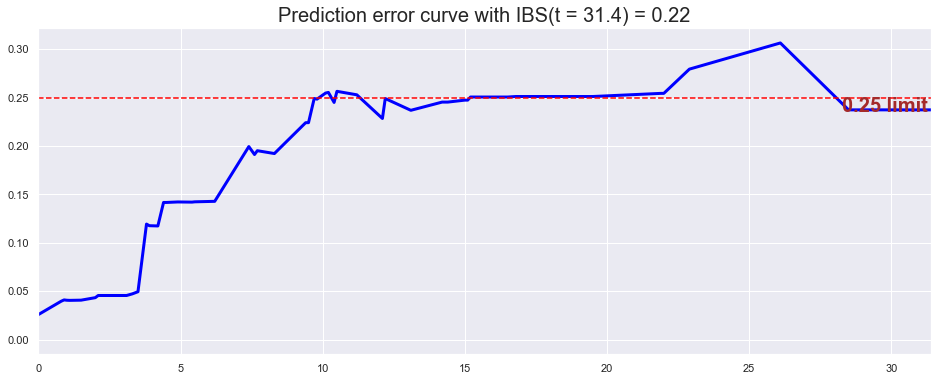

C-index: 0.53
IBS: 0.22

 3 of kfold 4


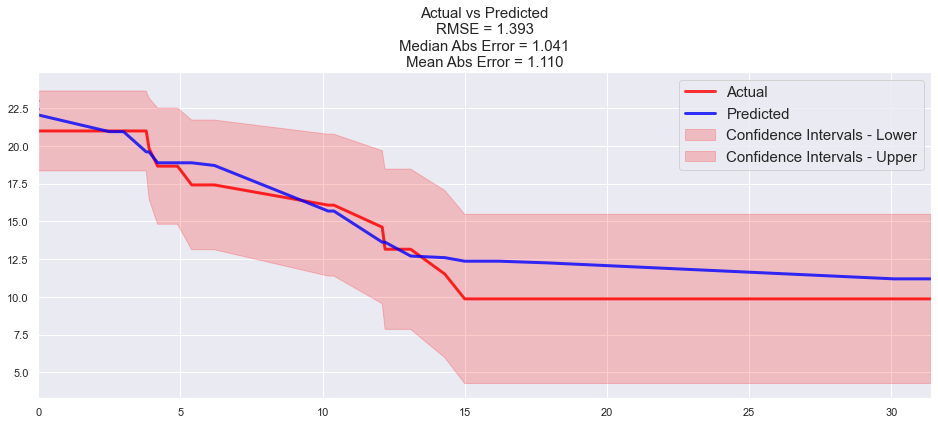

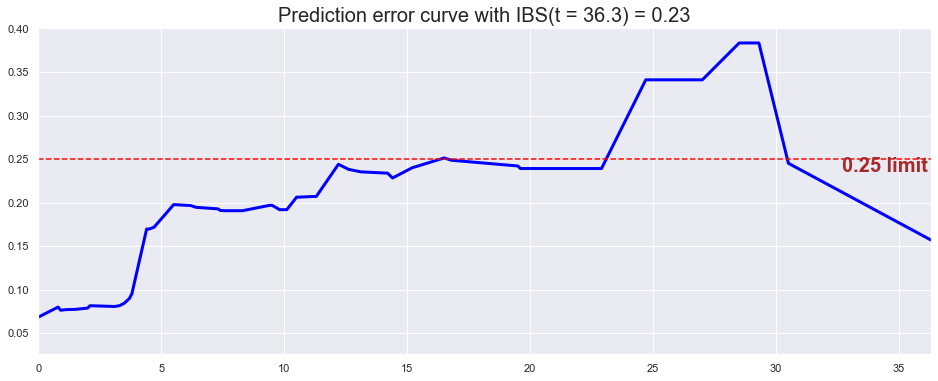

C-index: 0.57
IBS: 0.23

 4 of kfold 4


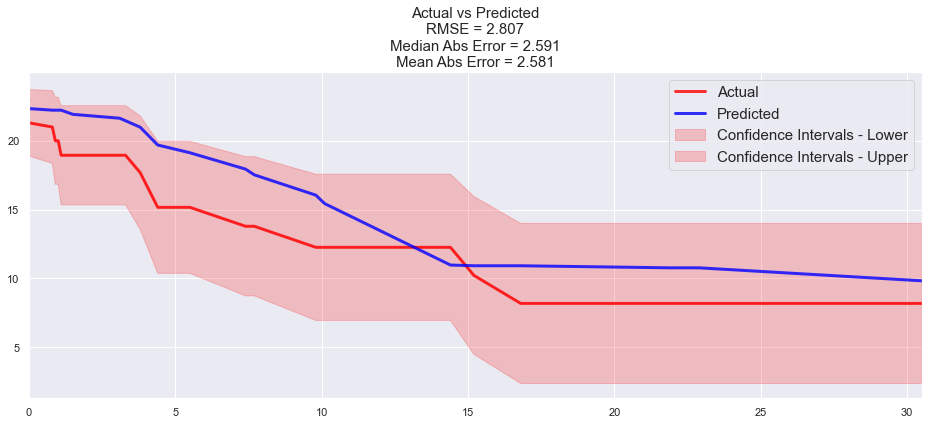

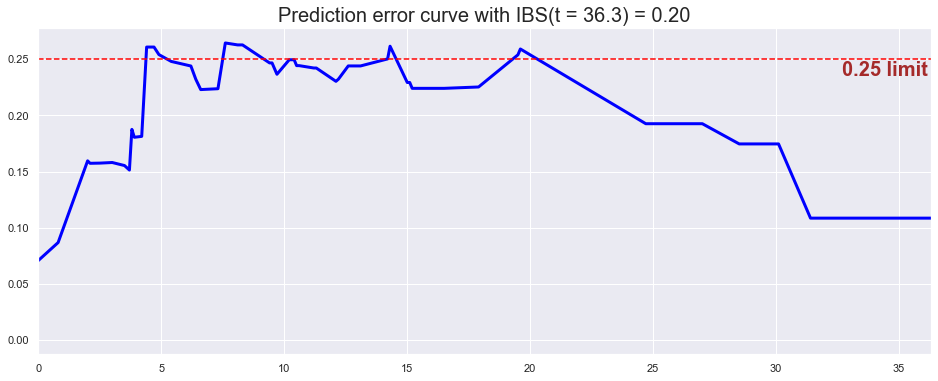

C-index: 0.69
IBS: 0.20

 

Processing: clin_variables_dosimetric_fflp.csv

Feature Selecting... 

Computing feature selection...

dropping 'FFLP_in_months' at index: 9
dropping 'FFLP' at index: 9
dropping 'D95 (% of intended Rx dose)' at index: 3
dropping 'MinDosePTV (cGy)' at index: 1
dropping 'BED (in Gy)' at index: 0
dropping 'SystemicBeforeRT' at index: 1
Remaining variables:
Index(['Dmax (cGy)', 'Lines of chemo', 'PumpBeforeRT', 'CEAatRT',
       'KRASmutation', 'time column', 'event column'],
      dtype='object')
Final dataset: 
     PumpBeforeRT  Lines of chemo  CEAatRT  Dmax (cGy)  time column  \
0              0               3      6.9      3145.0          0.8   
1              0               2      8.4      3586.0         14.4   
2              1               2     10.2      2650.0          4.2   
3              1               4      4.7      4878.6          3.9   
4              1               4      4.7      4878.6          1.1   
..           ...             ...    

20 1 2 0.7006313585840357
20 1 3 0.703361411060505
20 1 4 0.6857288535044422
20 1 5 0.6878907883143998
20 1 10 0.7126322929638648
20 1 12 0.6694558707973083
20 1 15 0.6785383863120911
20 1 20 0.7100385020693906
20 2 1 0.7095114749688465
20 2 2 0.6675811557285956
20 2 3 0.7167514329593155
20 2 4 0.6804972563785507
20 2 5 0.6973069430848569
20 2 10 0.6849675657982891
20 2 12 0.7129519750748299
20 2 15 0.7014218865903945
20 2 20 0.6980098216187447
20 3 1 0.7044443894381038
20 3 2 0.7180302780128879
20 3 3 0.649248443130083
20 3 4 0.6960531087309355
20 3 5 0.6785314351091738
20 3 10 0.7285578688897663
20 3 12 0.7224246957735239
20 3 15 0.7162709117084654
20 3 20 0.6857429123261282
20 4 1 0.7257355074941729
20 4 2 0.6841553183929716
20 4 3 0.681126584127797
20 4 4 0.6633237467601589
20 4 5 0.6995026653171302
20 4 10 0.7018231029233387
20 4 12 0.6977069412017127
20 4 15 0.7001196451690673
20 4 20 0.7096067906818548
20 5 1 0.7313629130380861
20 5 2 0.7007924579453296
20 5 3 0.6578627391470361

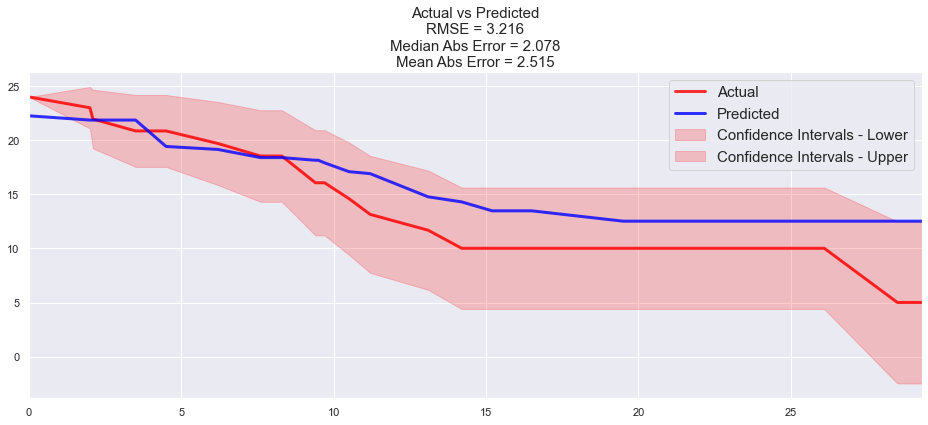

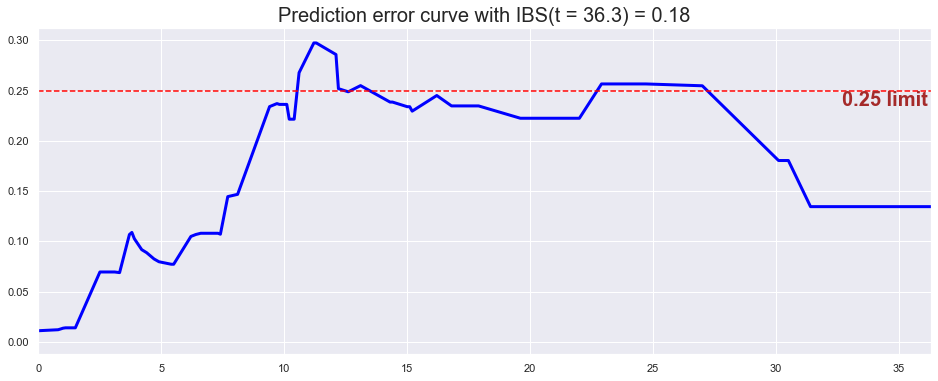

C-index: 0.66
IBS: 0.18

 2 of kfold 4


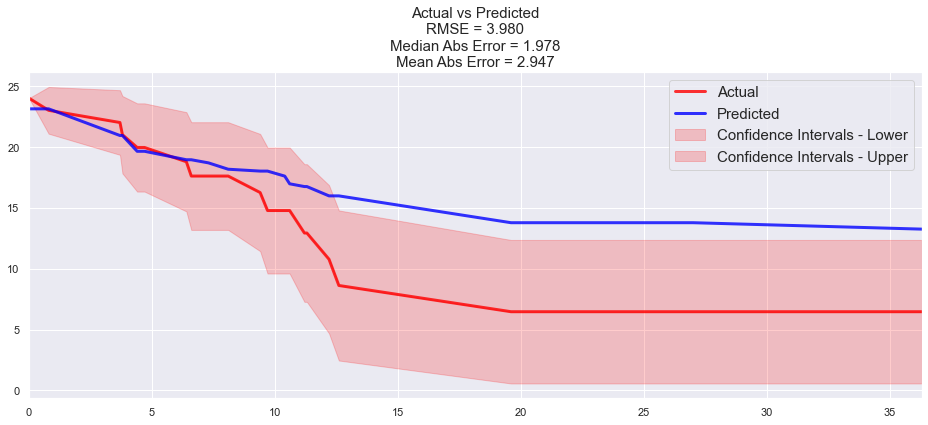

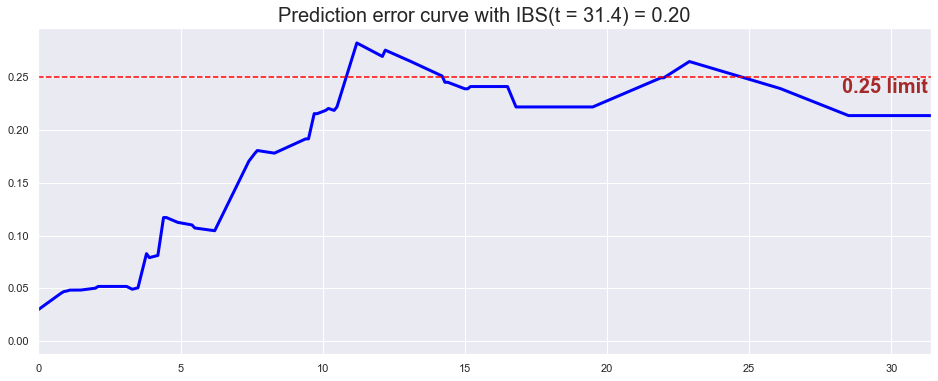

C-index: 0.71
IBS: 0.20

 3 of kfold 4


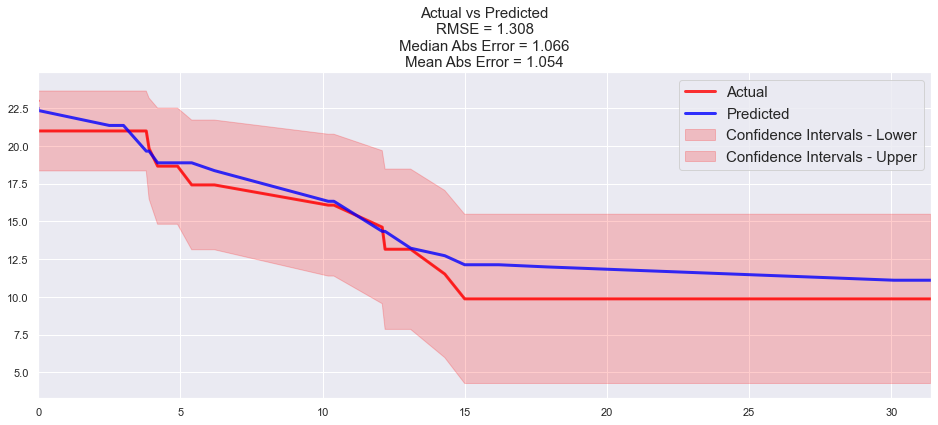

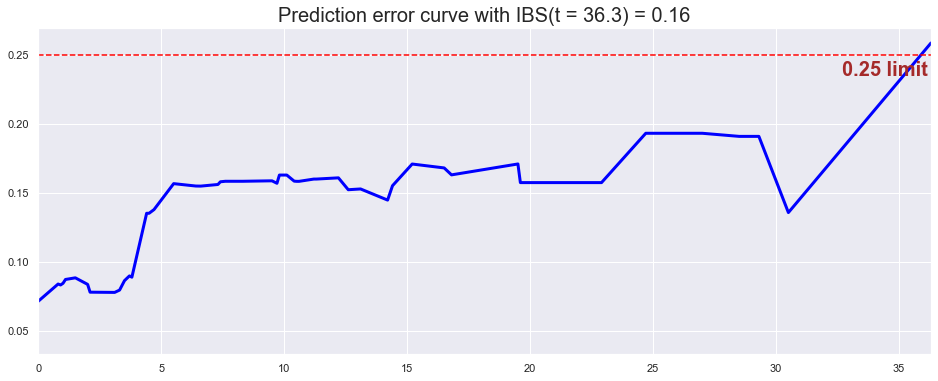

C-index: 0.79
IBS: 0.16

 4 of kfold 4


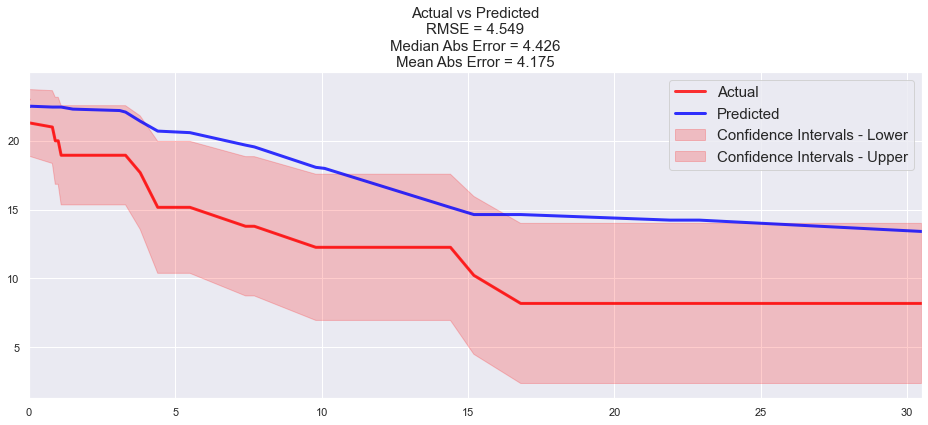

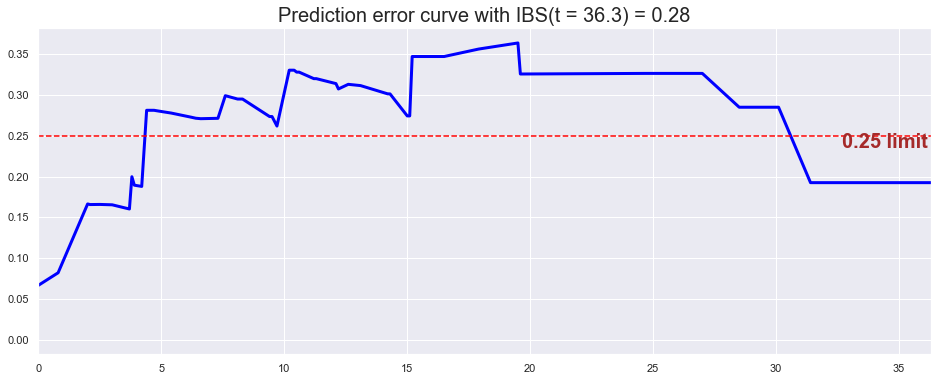

C-index: 0.53
IBS: 0.28

 

Processing: clin_variables_imaging_hp.csv

Feature Selecting... 

Computing feature selection...

dropping 'AnyHepaticProgression' at index: 5
dropping 'TimeToAnyHepaticProgression' at index: 5
dropping 'Lesion1Dim2' at index: 3
Remaining variables:
Index(['NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1',
       'PTVvolume (cm^3)', 'time column', 'event column'],
      dtype='object')
Final dataset: 
     NumLiverLesionsAtRT  Lesion1Dim1  PTVvolume (cm^3)  time column  \
0                     1         33.0             94.36          0.8   
1                     1         69.7             52.31         14.4   
2                     1         31.4             35.67          4.2   
3                     2         48.2             53.08         15.2   
4                     2          6.6             53.08          2.0   
..                  ...          ...               ...          ...   
89                    4         56.4            104.81          

20 1 10 0.6044187771328874
20 1 12 0.6169367062618617
20 1 15 0.6047466006181933
20 1 20 0.6263499080824022
20 2 1 0.5549706316622757
20 2 2 0.6106414583016355
20 2 3 0.598186516369236
20 2 4 0.5944809074399876
20 2 5 0.5889580968657914
20 2 10 0.6255572516660194
20 2 12 0.6049271767731623
20 2 15 0.6124187085817328
20 2 20 0.6417950079806357
20 3 1 0.6037081536965276
20 3 2 0.6042148902396481
20 3 3 0.5925375005165707
20 3 4 0.619287356783886
20 3 5 0.5817055651935504
20 3 10 0.598152716951863
20 3 12 0.6010787097526564
20 3 15 0.6661121157841979
20 3 20 0.6330201252346815
20 4 1 0.6040194628402824
20 4 2 0.5927391986200127
20 4 3 0.5800514871620122
20 4 4 0.6028827380813047
20 4 5 0.6160051958381987
20 4 10 0.6290824919806434
20 4 12 0.5968724042638714
20 4 15 0.6022041062253309
20 4 20 0.6493853071613863
20 5 1 0.5651684498122111
20 5 2 0.5821097524992782
20 5 3 0.6120218847965317
20 5 4 0.6121795191225305
20 5 5 0.609311219537192
20 5 10 0.6253913565022918
20 5 12 0.641767957294069

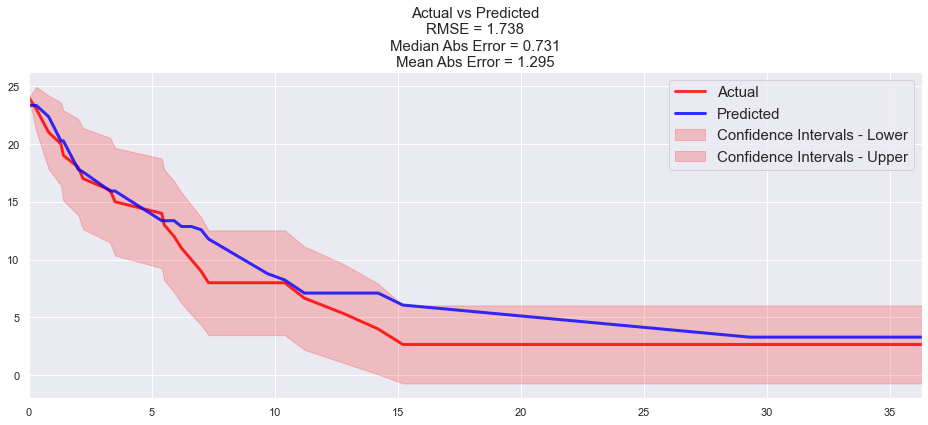

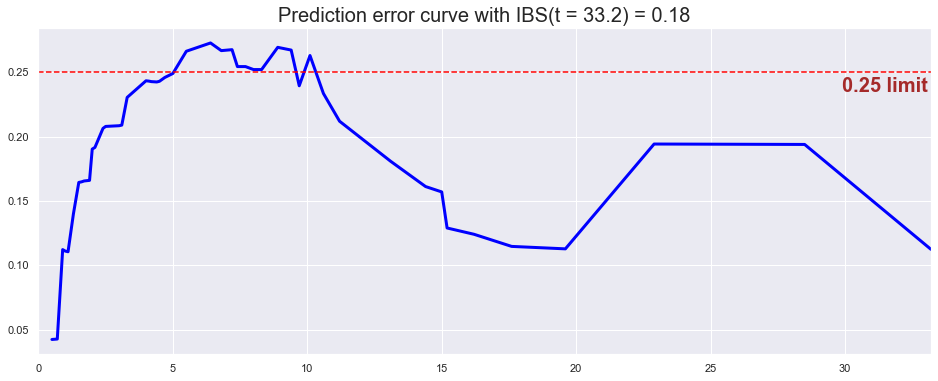

C-index: 0.59
IBS: 0.18

 2 of kfold 4


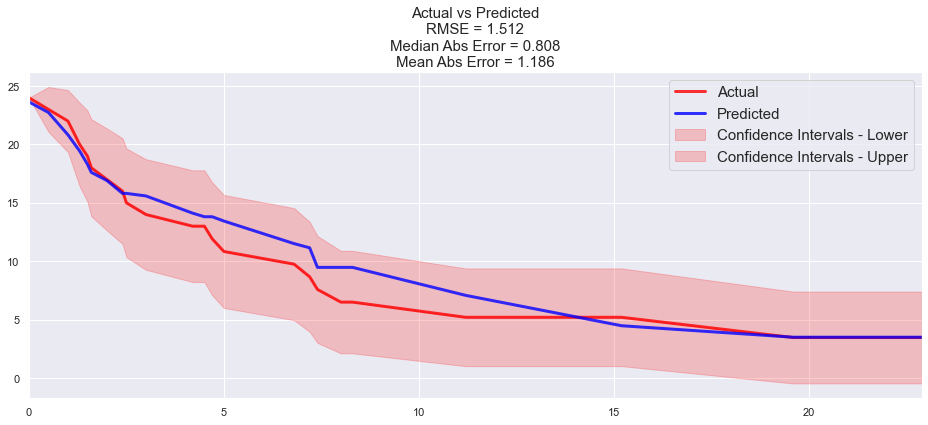

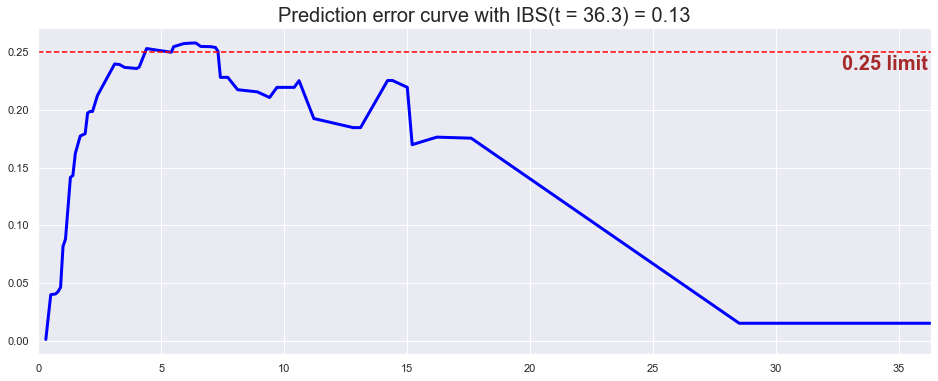

C-index: 0.56
IBS: 0.13

 3 of kfold 4


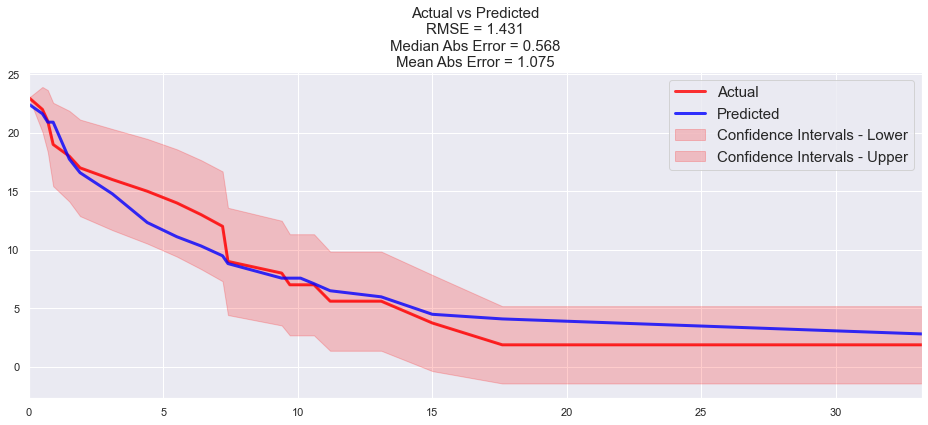

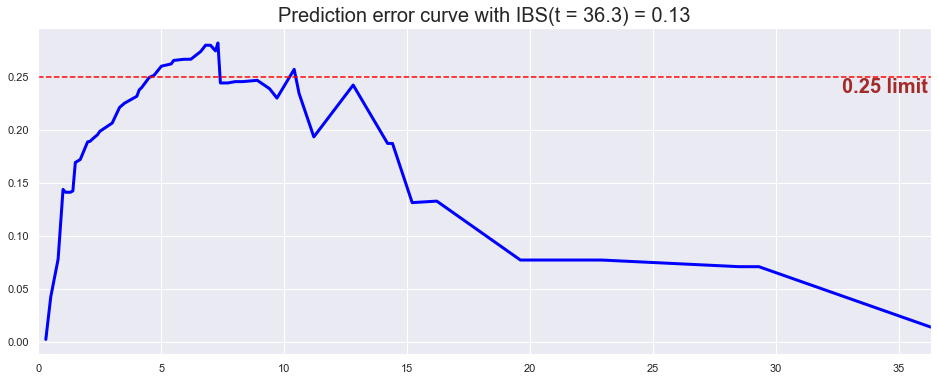

C-index: 0.51
IBS: 0.13

 4 of kfold 4


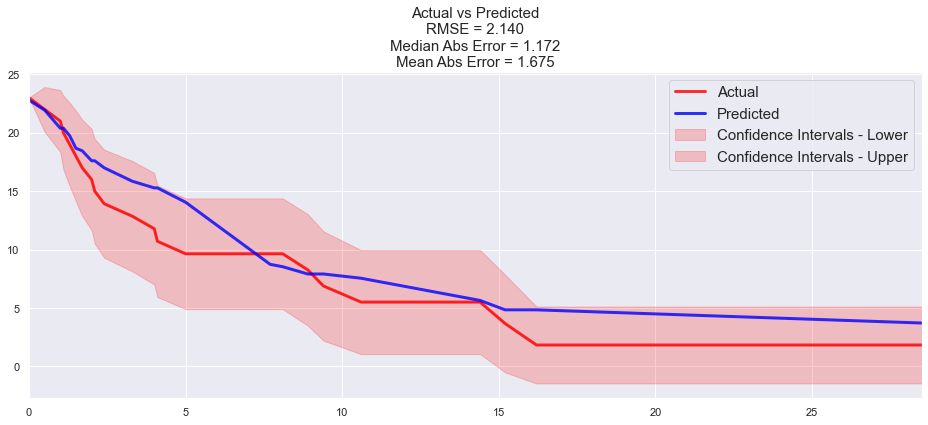

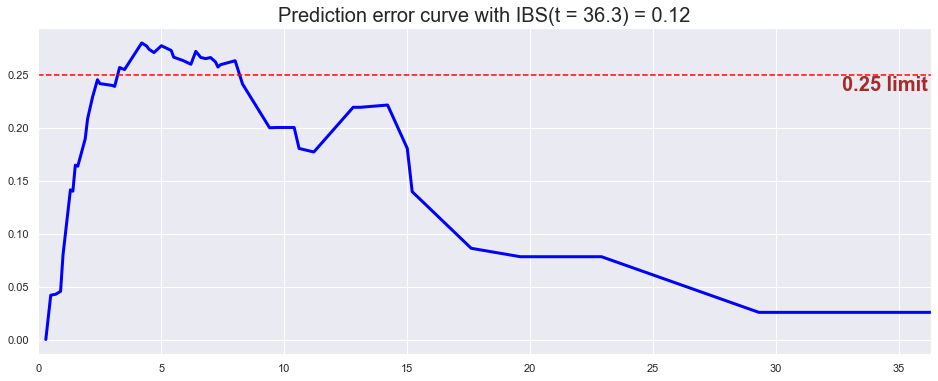

C-index: 0.53
IBS: 0.12

 

Processing: clin_variables_non_imaging_hp.csv

Feature Selecting... 

Computing feature selection...

dropping 'AnyHepaticProgression' at index: 33
dropping 'TimeToAnyHepaticProgression' at index: 33
dropping 'Histology' at index: 1
dropping 'RTPlanDose' at index: 8
dropping 'Intended Rx dose' at index: 10
dropping 'D95 (dose in cGy)' at index: 14
dropping 'Dmax (cGy)' at index: 13
dropping 'D95 (% of intended Rx dose)' at index: 13
dropping 'BED (in Gy)' at index: 11
dropping 'RTFxDeliv' at index: 7
dropping 'SystemicBeforeRT' at index: 14
dropping 'RTDoseDeliv' at index: 7
dropping 'MinDosePTV (cGy)' at index: 9
dropping 'Gender' at index: 0
Remaining variables:
Index(['HistologyGranular', 'cM at diagnosis', 'NumLiverLesionsAtDx',
       'OtherSitesAtDx', 'RTtoOtherSites', 'RTnumFx', 'DosePainting',
       'Dose per fx', 'LiverLocation2Tx', 'ReTx', 'SurgeryBeforeRT',
       'Lines of chemo', 'PumpBeforeRT', 'RFAbeforeRT', 'RFAtoRTlesions',
       'Y90Befor

15 4 2 0.6378711058015557
15 4 3 0.6266738198370136
15 4 4 0.5971052292855541
15 4 5 0.604807567969008
15 4 10 0.5987436252169563
15 4 12 0.5687729778883581
15 4 15 0.582562240556577
15 4 20 0.5799770828008053
15 5 1 0.6128723815680593
15 5 2 0.6167162616708721
15 5 3 0.5821595887732633
15 5 4 0.600833544005194
15 5 5 0.5963762939089646
15 5 10 0.6232405388201989
15 5 12 0.5938825750731704
15 5 15 0.5549734735961683
15 5 20 0.5853183168122983
15 6 1 0.5939088382123114
15 6 2 0.6115095613029152
15 6 3 0.5911625468983951
15 6 4 0.629658369248003
15 6 5 0.5844004925398277
15 6 10 0.6279193800286699
15 6 12 0.6064538343783249
15 6 15 0.5518035882791669
15 6 20 0.6175476702009473
15 10 1 0.6552648441082349
15 10 2 0.6060890125365912
15 10 3 0.5929573249415845
15 10 4 0.6038555199586022
15 10 5 0.6057860317623718
15 10 10 0.5682922888325824
15 10 12 0.6176978455772559
15 10 15 0.5990216776422572
15 10 20 0.5926760914849784
15 12 1 0.6254120036645202
15 12 2 0.6051267490601616
15 12 3 0.58945

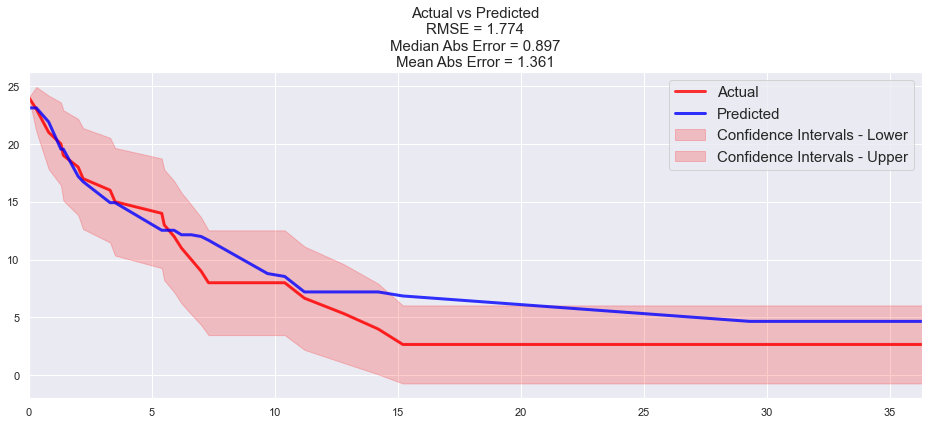

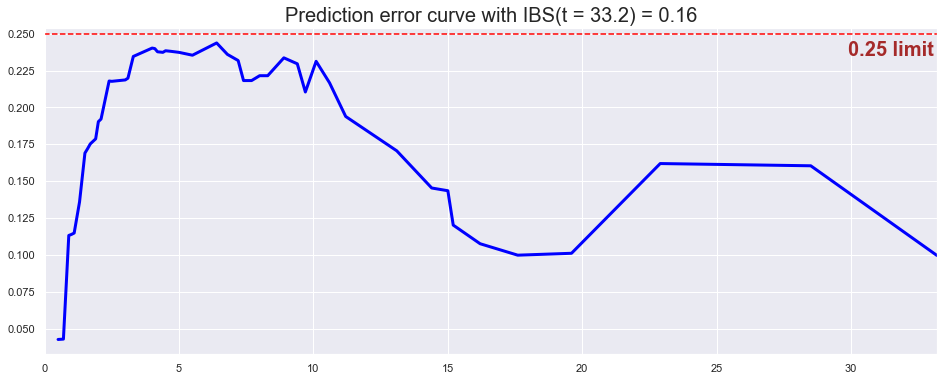

C-index: 0.57
IBS: 0.16

 2 of kfold 4


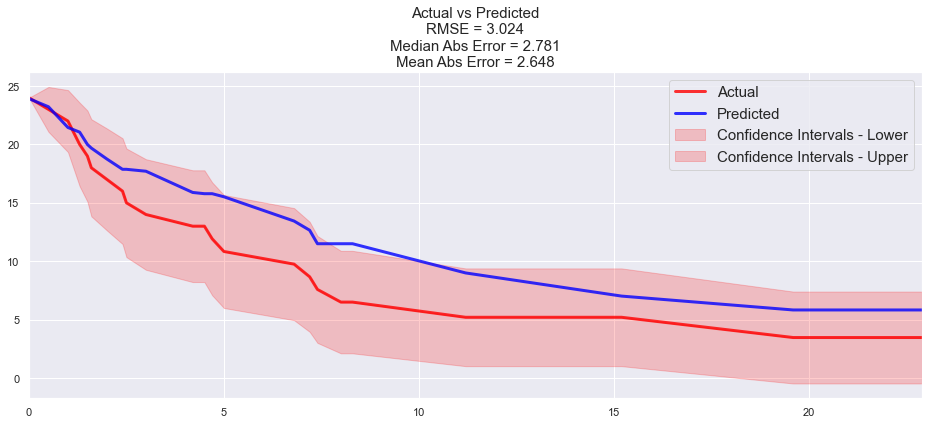

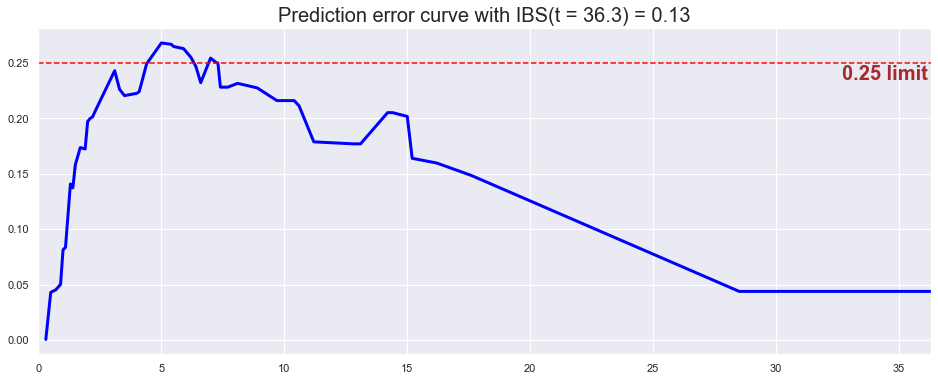

C-index: 0.60
IBS: 0.13

 3 of kfold 4


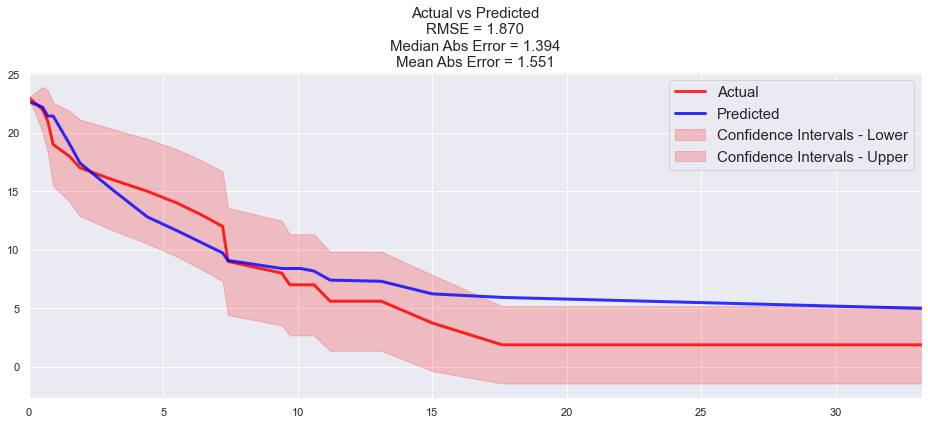

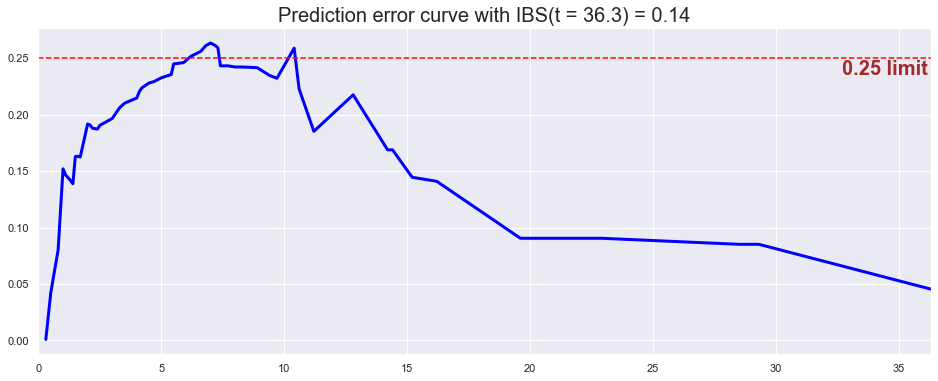

C-index: 0.51
IBS: 0.14

 4 of kfold 4


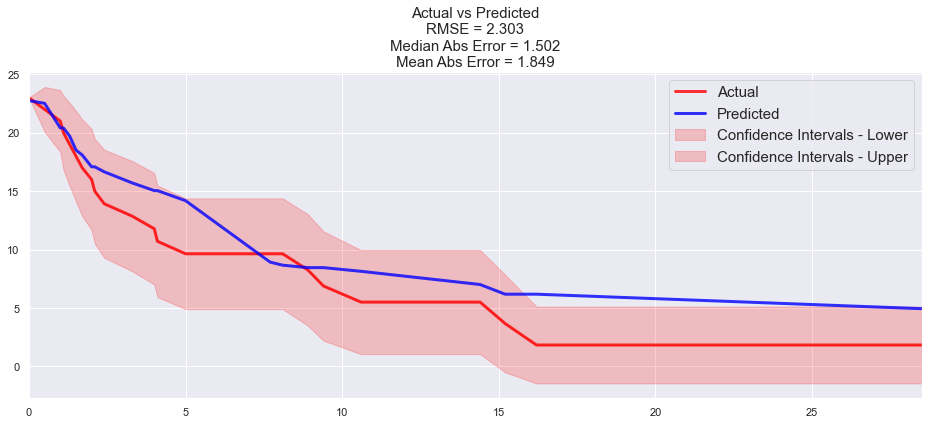

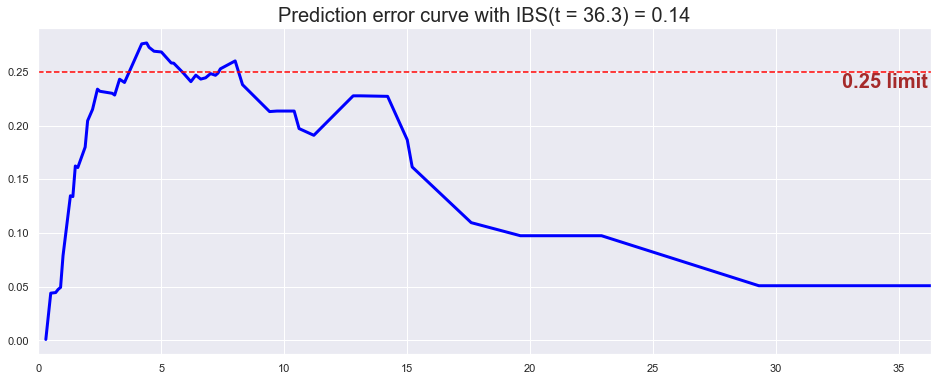

C-index: 0.59
IBS: 0.14

 

Processing: clin_variables_dosimetric_hp.csv

Feature Selecting... 

Computing feature selection...

dropping 'AnyHepaticProgression' at index: 9
dropping 'TimeToAnyHepaticProgression' at index: 9
dropping 'D95 (% of intended Rx dose)' at index: 3
dropping 'MinDosePTV (cGy)' at index: 1
dropping 'SystemicBeforeRT' at index: 2
dropping 'BED (in Gy)' at index: 0
Remaining variables:
Index(['Dmax (cGy)', 'Lines of chemo', 'PumpBeforeRT', 'CEAatRT',
       'KRASmutation', 'time column', 'event column'],
      dtype='object')
Final dataset: 
     Lines of chemo  KRASmutation  CEAatRT  Dmax (cGy)  time column  \
0                3             0      6.9      3145.0          0.8   
1                2             0      8.4      3586.0         14.4   
2                2             0     10.2      2650.0          4.2   
3                4             0      4.7      4878.6         15.2   
4                4             0      4.7      4878.6          2.0   
..      

20 1 1 0.575599702568313
20 1 2 0.5859961660267262
20 1 3 0.5831213811349382
20 1 4 0.6222524535636623
20 1 5 0.6165364468920395
20 1 10 0.571319056055501
20 1 12 0.592983349587685
20 1 15 0.5965212482676173
20 1 20 0.6189549414635349
20 2 1 0.5933272674442326
20 2 2 0.6049347138362132
20 2 3 0.5900713249916465
20 2 4 0.5932915996616959
20 2 5 0.5976910427124056
20 2 10 0.6132977253591072
20 2 12 0.5868201756452892
20 2 15 0.5811053415711995
20 2 20 0.6289445848915909
20 3 1 0.5974144698969741
20 3 2 0.6037176968022842
20 3 3 0.6333351271355064
20 3 4 0.6329811203171061
20 3 5 0.6067956933444356
20 3 10 0.5905790940584598
20 3 12 0.5907393270489515
20 3 15 0.6151235068202671
20 3 20 0.6022866081682399
20 4 1 0.6147589304636438
20 4 2 0.6165072621309269
20 4 3 0.6099665835072438
20 4 4 0.6234368771013494
20 4 5 0.5981058814674197
20 4 10 0.5709357424097642
20 4 12 0.6139590068902092
20 4 15 0.6015621044043161
20 4 20 0.6006714556781181
20 5 1 0.6336568724076636
20 5 2 0.6150119390834763

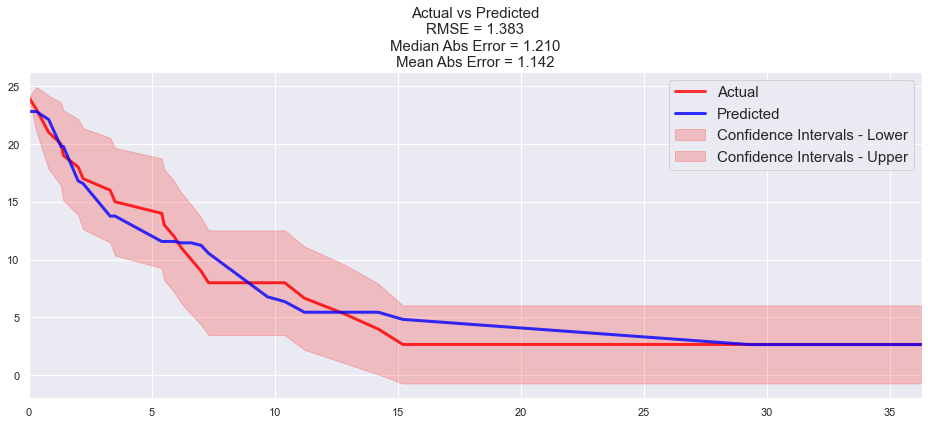

C-index: 0.54
IBS: 0.16

 2 of kfold 4


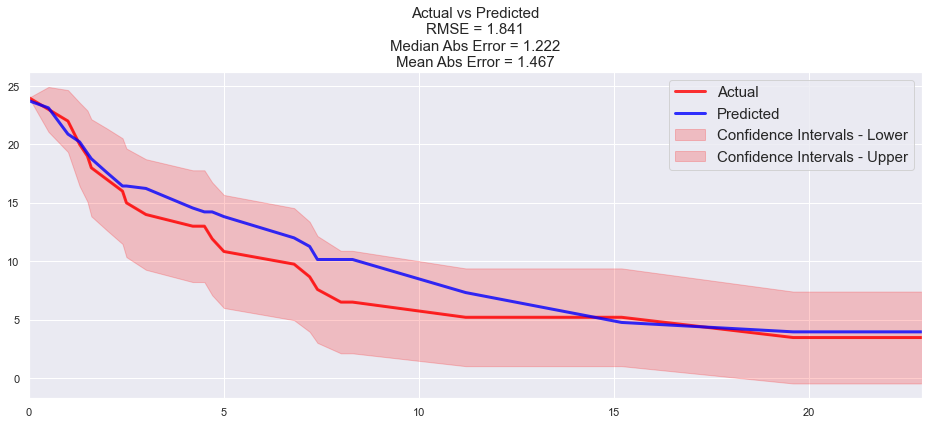

C-index: 0.72
IBS: 0.11

 3 of kfold 4


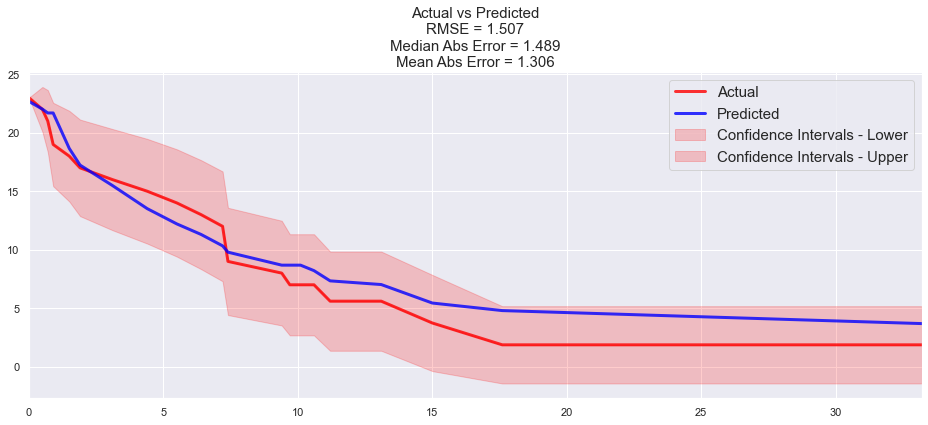

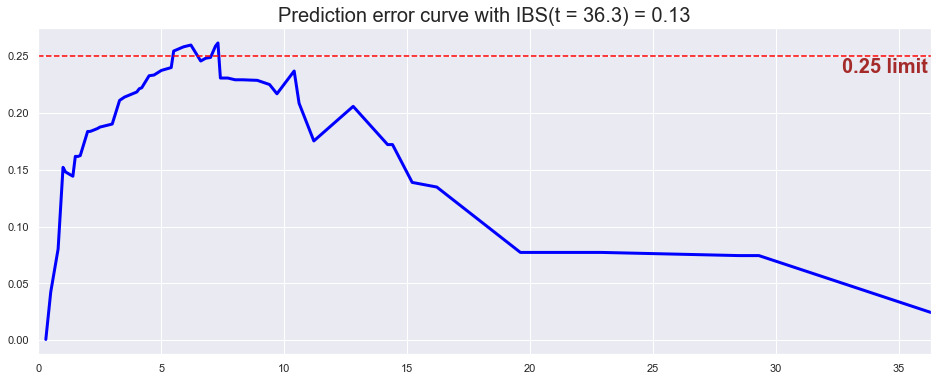

C-index: 0.57
IBS: 0.13

 4 of kfold 4


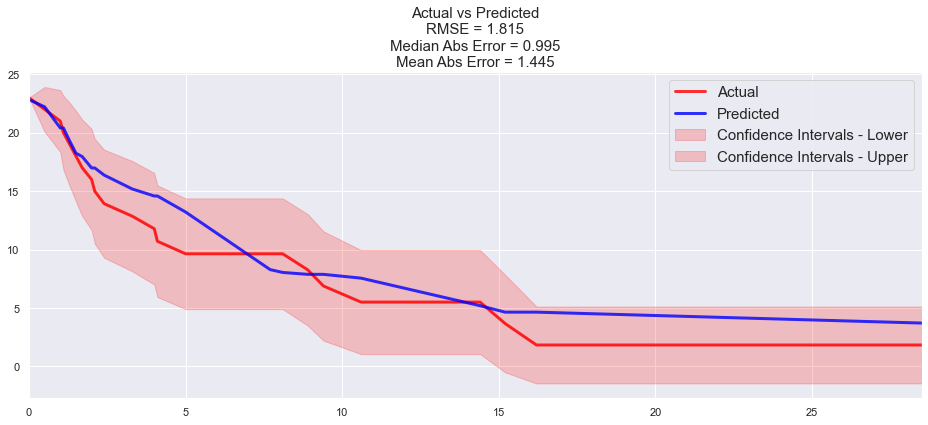

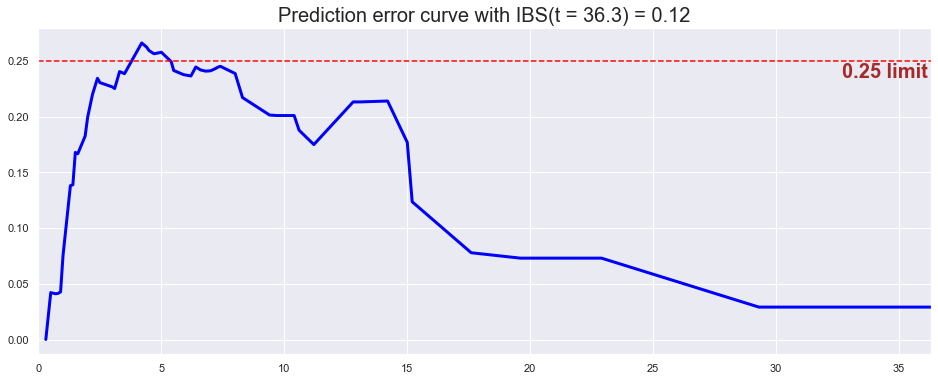

C-index: 0.64
IBS: 0.12

 

                                   Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.788691  0.654798   
1                     liver_sub_gtv.csv            0.866698  0.757923   
2                    liver_plus_gtv.csv            0.772054  0.634736   
3                            gtv_hp.csv            0.731151  0.613234   
4                  liver_sub_gtv_hp.csv            0.675034  0.517526   
5                 liver_plus_gtv_hp.csv            0.868618  0.815275   
6       clin_variables_imaging_fflp.csv            0.754029  0.615647   
7   clin_variables_non_imaging_fflp.csv            0.710491  0.578382   
8    clin_variables_dosimetric_fflp.csv            0.775559  0.672956   
9         clin_variables_imaging_hp.csv            0.682625  0.548221   
10    clin_variables_non_imaging_hp.csv            0.660904  0.568906   
11     clin_variables_dosimetric_hp.csv            0.653409  0.616859   

      CI STD   IBS Avg

In [57]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

In [58]:
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.788691  0.654798   
1                     liver_sub_gtv.csv            0.866698  0.757923   
2                    liver_plus_gtv.csv            0.772054  0.634736   
3                            gtv_hp.csv            0.731151  0.613234   
4                  liver_sub_gtv_hp.csv            0.675034  0.517526   
5                 liver_plus_gtv_hp.csv            0.868618  0.815275   
6       clin_variables_imaging_fflp.csv            0.754029  0.615647   
7   clin_variables_non_imaging_fflp.csv            0.710491  0.578382   
8    clin_variables_dosimetric_fflp.csv            0.775559  0.672956   
9         clin_variables_imaging_hp.csv            0.682625  0.548221   
10    clin_variables_non_imaging_hp.csv            0.660904  0.568906   
11     clin_variables_dosimetric_hp.csv            0.653409  0.616859   

      CI STD   IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0   0.099502  0.182312  0.019542       20.0        1.0      12.0  
1   0.063861  0.196061  0.027077       15.0        6.0       1.0  
2   0.074556  0.217342  0.009214       20.0        5.0       1.0  
3   0.058359  0.163114  0.029252       20.0        4.0       2.0  
4   0.010974  0.133526  0.045983       10.0       10.0      10.0  
5   0.053803  0.125673  0.029067       12.0       10.0       3.0  
6   0.071449  0.189752  0.012759       10.0        1.0      20.0  
7   0.077723  0.215103  0.011931       12.0       12.0       2.0  
8   0.109643  0.205956  0.049177       15.0       12.0       2.0  
9   0.036566  0.140915  0.026985       12.0        1.0      12.0  
10  0.039365  0.141358  0.013402       12.0        5.0       4.0  
11  0.082571  0.129862  0.023866       10.0       10.0      15.0